In [2]:
#CNN LSTM
import numpy as np
import sqlite3
import pandas as pd
from itertools import combinations, product
import joblib
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Reshape
from tensorflow.keras.optimizers import Adam
import os
import random
import matplotlib.pyplot as plt

# Kelas untuk mengakses data spektrum
class SpectralDataProcessor:
    @staticmethod
    def get_spectral_data(db_path, element, sp_num):
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

# Kelas untuk simulasi spektrum dengan profil Gaussian
class SpectrumSimulator:
    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5  # eV/K
        intensity = (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z
        return intensity

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5  # eV/K
        Z = np.sum(degeneracies * np.exp(-np.array(energy_levels) / (k_B * T)))
        return Z

    @staticmethod
    def gaussian_profile(wavelengths, center_wl, intensity, fwhm):
        sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
        profile = intensity * np.exp(-0.5 * ((wavelengths - center_wl) / sigma) ** 2)
        return profile

    @staticmethod
    def simulate_spectrum(db_path, element, sp_num, temperature, wavelength_grid):
        spectral_data = SpectralDataProcessor.get_spectral_data(db_path, element, sp_num)

        # Inisialisasi spektrum total
        total_spectrum = np.zeros_like(wavelength_grid)

        energy_levels = []
        degeneracies = []

        # Kumpulkan energi dan degenerasi untuk fungsi partisi
        for wl, gA, Ek, Ei, gi, gk in spectral_data:
            if all(value is not None and value != '' for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek) / 8065.544, float(Ei) / 8065.544  # Konversi cm-1 ke eV
                    gi = float(gi)
                    gk = float(gk)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        # Hitung fungsi partisi
        Z = SpectrumSimulator.partition_function(energy_levels, degeneracies, temperature)

        # Simulasikan spektrum dengan profil Gaussian untuk setiap garis
        for wl, gA, Ek, Ei, gi, gk in spectral_data:
            if all(value is not None and value != '' for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek) / 8065.544, float(Ei) / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    energy = Ek
                    degeneracy = gi
                    einstein_coeff = gA
                    intensity = SpectrumSimulator.calculate_intensity(temperature, energy, degeneracy, einstein_coeff, Z)

                    # Tentukan FWHM (Full Width at Half Maximum) untuk profil Gaussian
                    fwhm = wl * 0.002  # 0.2% dari panjang gelombang

                    # Tambahkan profil Gaussian dari garis ini ke spektrum total
                    line_profile = SpectrumSimulator.gaussian_profile(wavelength_grid, wl, intensity, fwhm)
                    total_spectrum += line_profile
                except ValueError:
                    continue

        return total_spectrum

# Konfigurasi
db_path = 'data1.db'  # Path ke database spektrum Anda

# Daftar 7 elemen
elements = ['Ca', 'Fe', 'Mg', 'Na', 'K', 'Al', 'Si']

# Tahap ionisasi per elemen
ion_stages_per_element = {
    'Ca': [1, 2],
    'Fe': [1, 2],
    'Mg': [1, 2],
    'Na': [1],
    'K': [1],
    'Al': [1, 2],
    'Si': [1, 2]
}

temperatures = list(range(6000, 20000, 1000))  # Daftar temperatur
number_of_samples = 5000  # Jumlah sampel yang akan disimulasikan
max_elements_per_sample = 4  # Maksimum jumlah elemen per sampel

# Mendefinisikan grid panjang gelombang untuk simulasi spektrum
wavelength_grid = np.linspace(200, 900, 24880)  # 24,880 titik antara 200 nm dan 900 nm

# Fungsi untuk mensimulasikan spektrum multi-elemen
def simulate_multi_element_spectrum(db_path, elements, ion_stages, temperature, wavelength_grid):
    total_spectrum = np.zeros_like(wavelength_grid)

    for element, ion_stage in zip(elements, ion_stages):
        element_spectrum = SpectrumSimulator.simulate_spectrum(db_path, element, ion_stage, temperature, wavelength_grid)
        total_spectrum += element_spectrum

    return total_spectrum

# Pembuatan dataset
samples = []
labels = []

all_elements = elements
temperatures_sampling = temperatures

for _ in range(number_of_samples):
    # Pilih jumlah elemen acak
    num_elements = random.randint(1, max_elements_per_sample)
    # Pilih elemen dan ion stage secara acak
    selected_elements = random.sample(all_elements, k=num_elements)
    selected_ion_stages = []
    for element in selected_elements:
        selected_ion_stages.append(random.choice(ion_stages_per_element[element]))
    temperature = random.choice(temperatures_sampling)

    # Simulasikan spektrum multi-elemen
    spectrum = simulate_multi_element_spectrum(db_path, selected_elements, selected_ion_stages, temperature, wavelength_grid)

    # Jika spektrum kosong, lewati iterasi ini
    if np.max(spectrum) == 0:
        continue

    # Normalisasi intensitas
    spectrum = spectrum / np.max(spectrum)

    # Binning spektrum untuk mendapatkan fitur dengan dimensi tetap
    bins = np.linspace(200, 900, 700)  # Pastikan bins sama dengan yang akan digunakan saat prediksi
    binned_intensities, _ = np.histogram(wavelength_grid, bins=bins, weights=spectrum)
    binned_intensities = binned_intensities / np.max(binned_intensities)  # Normalisasi

    samples.append(binned_intensities)
    labels.append(selected_elements)

# Konversi ke array NumPy
X = np.array(samples)
y = labels

# Encode label menggunakan MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)

# Split data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Bentuk data untuk input ke model CNN-LSTM
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Bangun model CNN-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2, padding='same'))
model.add(Dropout(0.2))

# Reshape data untuk input ke LSTM
model.add(Reshape((model.layers[-1].output_shape[1], model.layers[-1].output_shape[2])))

model.add(LSTM(100))
model.add(Dense(len(mlb.classes_), activation='sigmoid'))

# Kompilasi model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi model: {accuracy*100:.2f}%")

# Simpan model dan encoder
model.save('multi_element_spectrum_model_gaussian_cnn_lstm.h5')
joblib.dump(mlb, 'multilabel_binarizer_gaussian_cnn_lstm.pkl')
print("Model dan MultiLabelBinarizer berhasil disimpan.")

# Plot grafik akurasi dan loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Latih')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Latih')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: 'Dropout' object has no attribute 'output_shape'

1.5511199871861


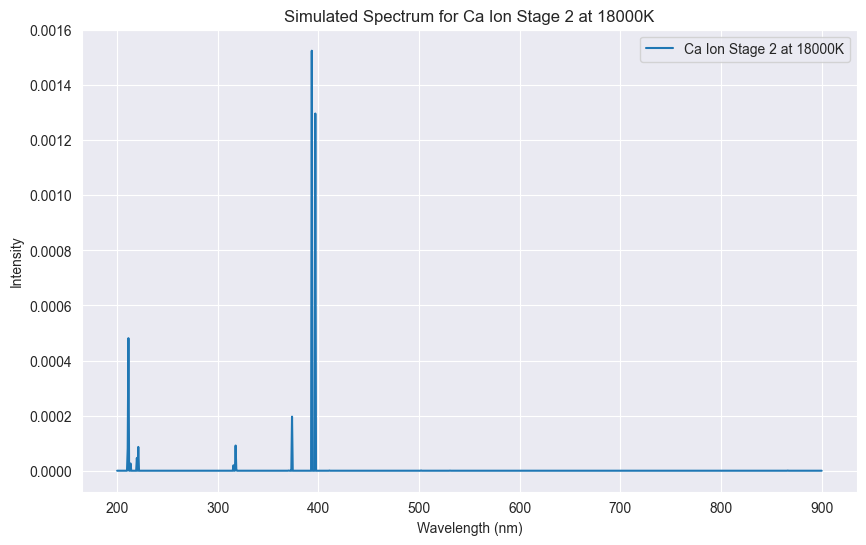

In [22]:
import numpy as np
import sqlite3
import random
import matplotlib.pyplot as plt

class a:
    @staticmethod
    def get_spectral_data(db_path, element, sp_num):
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

class b:
    @staticmethod
    def calculate_intensity(T, Ek, Ei, Aki, wavelength, Z):
        k_B = 8.617333262145e-5  # eV/K
        delta_E = Ek - Ei  # Energi transisi (eV)
        if delta_E <= 0:
            return 0
        intensity = (Aki * delta_E * np.exp(-Ek / (k_B * T))) / (Z * wavelength**4)
        return intensity

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5  # eV/K
        Z = np.sum([g * np.exp(-E / (k_B * T)) for g, E in zip( degeneracies, energy_levels)])
        return Z

    @staticmethod
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))

    @staticmethod
    def simulate_spectrum(db_path, element, sp_num, temperature, resolution):
        spectral_data = a.get_spectral_data(db_path, element, sp_num)
        wavelengths = np.linspace(200, 900, resolution)
        intensities = np.zeros_like(wavelengths)

        energy_levels = []
        degeneracies = []

        # Kumpulkan tingkat energi dan degenerasi unik
        for wl, gA, Ek, Ei, gi, gk in spectral_data:
            if all(value is not None and value != '' for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    Ei = float(Ei) / 8065.544  # cm^-1 ke eV
                    Ek = float(Ek) / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    energy_levels.extend([Ei, Ek])
                    degeneracies.extend([gi, gk])
                except ValueError:
                    continue

        # Hapus duplikat
        unique_levels = list(set(zip(energy_levels, degeneracies)))
        energy_levels, degeneracies = zip(*unique_levels)

        Z = b.partition_function(energy_levels, degeneracies, temperature)

        # Hitung intensitas
        for wl, gA, Ek, Ei, gi, gk in spectral_data:
            if all(value is not None and value != '' for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek) / 8065.544
                    Ei = float(Ei) / 8065.544
                    gk = float(gk)
                    Aki = gA / gk  # Koefisien Einstein A_ki
                    intensity = b.calculate_intensity(temperature, Ek, Ei, Aki, wl, Z)
                    sigma = 0.1  # Lebar garis
                    intensities += intensity * b.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue

        return wavelengths, intensities

# Penggunaan kode
db_path = 'data1.db'
resolution = 24880
elements = ['Fe', 'O', 'Na', 'Ca', 'Mg', 'Si', 'Al', 'K', 'Ti', 'Cr']
ion_stages = [1, 2]
temperatures = list(range(6000, 20001, 500))

selected_element = "Ca"
selected_ion_stage = 2
selected_temperature = random.choice(temperatures)

# Simulasi spektrum
wavelengths, intensities = b.simulate_spectrum(db_path, selected_element, selected_ion_stage, selected_temperature, resolution=1000)

# Plot hasil
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, intensities, label=f'{selected_element} Ion Stage {selected_ion_stage} at {selected_temperature}K')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.title(f'Simulated Spectrum for {selected_element} Ion Stage {selected_ion_stage} at {selected_temperature}K')
print(selected_temperature*8.617333262145e-5)
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 35s 266ms/step - accuracy: 0.3813 - loss: 0.5334 - val_accuracy: 0.2420 - val_loss: 0.6764
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 46s 368ms/step - accuracy: 0.5276 - loss: 0.2688 - val_accuracy: 0.2690 - val_loss: 0.9704
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 363ms/step - accuracy: 0.5617 - loss: 0.1907 - val_accuracy: 0.3520 - val_loss: 1.2353
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 374ms/step - accuracy: 0.5445 - loss: 0.1743 - val_accuracy: 0.2990 - val_loss: 1.1618
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 47s 375ms/step - accuracy: 0.5533 - loss: 0.1541 - val_accuracy: 0.4760 - val_loss: 0.8345
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 48s 385ms/step - accuracy: 0.5636 - loss: 0.1374 - val_accuracy: 0.4960 - val_loss: 0.2431
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 50s 397ms/step - accuracy: 0.5524 - loss: 0.1220 - val_accuracy: 0.5520 - val_loss: 0.3086
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 49s 389ms/step - accuracy: 0.5717 - loss: 0.1169 - val

Akurasi model: 52.10%
Model dan MultiLabelBinarizer berhasil disimpan.


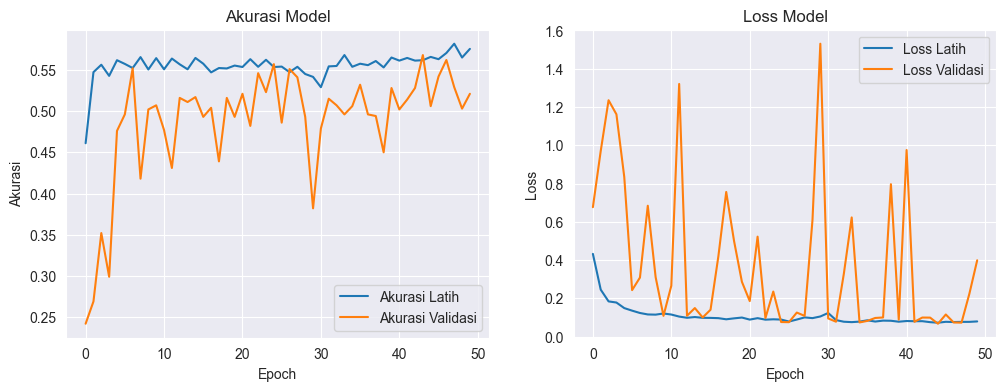

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Sampel S1: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sampel S2: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg', 'Na')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sampel S3: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg', 'Na')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sampel S4: Elemen yang diprediksi: [('Fe', 'Mg', 'Na')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sampel S5: Elemen yang diprediksi: [('Fe', 'K', 'Mg', 'Na')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Sampel S6: Elemen yang diprediksi: [('Fe', 'K', 'Mg', 'Na')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sampel S7: Elemen yang diprediksi: [('Fe', 'K', 'Mg', 'Na')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sampel S8: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg', 'Na')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sampel S9: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg', 'Na')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sampel S10: Elemen yang diprediksi: [('Fe', 'K', 'M

In [1]:
#CNN bi LIBS
import numpy as np
import sqlite3
import random
import joblib
from itertools import product
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Kelas untuk mengakses data spektrum
class SpectralDataProcessor:
    @staticmethod
    def get_spectral_data(db_path, element, sp_num):
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data

# Kelas untuk simulasi spektrum dengan profil Gaussian
class SpectrumSimulator:
    @staticmethod
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5  # eV/K
        intensity = (degeneracy * np.exp(-energy / (k_B * T)) * einstein_coeff) / Z
        return intensity

    @staticmethod
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5  # eV/K
        Z = np.sum(degeneracies * np.exp(-np.array(energy_levels) / (k_B * T)))
        return Z

    @staticmethod
    def gaussian_profile(wavelengths, center_wl, intensity, fwhm):
        sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
        profile = intensity * np.exp(-0.5 * ((wavelengths - center_wl) / sigma) ** 2)
        return profile

    @staticmethod
    def simulate_spectrum(db_path, element, sp_num, temperature, wavelength_grid):
        spectral_data = SpectralDataProcessor.get_spectral_data(db_path, element, sp_num)

        # Inisialisasi spektrum total
        total_spectrum = np.zeros_like(wavelength_grid)

        energy_levels = []
        degeneracies = []

        # Kumpulkan energi dan degenerasi untuk fungsi partisi
        for wl, gA, Ek, Ei, gi, gk in spectral_data:
            if all(value is not None and value != '' for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek) / 8065.544, float(Ei) / 8065.544  # Convert cm-1 to eV
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                except ValueError:
                    continue

        # Hitung fungsi partisi
        Z = SpectrumSimulator.partition_function(energy_levels, degeneracies, temperature)

        # Simulasikan spektrum dengan profil Gaussian untuk setiap garis
        for wl, gA, Ek, Ei, gi, gk in spectral_data:
            if all(value is not None and value != '' for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek) / 8065.544, float(Ei) / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    energy = Ek
                    degeneracy = gi
                    einstein_coeff = gA
                    intensity = SpectrumSimulator.calculate_intensity(temperature, energy, degeneracy, einstein_coeff, Z)

                    # Tentukan FWHM (Full Width at Half Maximum) untuk profil Gaussian
                    fwhm = wl * 0.002  # 0.2% dari panjang gelombang

                    # Tambahkan profil Gaussian dari garis ini ke spektrum total
                    line_profile = SpectrumSimulator.gaussian_profile(wavelength_grid, wl, intensity, fwhm)
                    total_spectrum += line_profile
                except ValueError:
                    continue

        return total_spectrum

# Konfigurasi
db_path = 'data1.db'  # Path ke database spektrum Anda
elements = ['Ca', 'Fe', 'Mg', 'Na', 'K', 'Al', 'Si']  # Daftar elemen yang diperluas
ion_stages_per_element = {
    'Ca': [1, 2],
    'Fe': [1, 2],
    'Mg': [1, 2],
    'Na': [1, 2],
    'K': [1, 2],
    'Al': [1, 2],
    'Si': [1, 2]
}
temperatures = list(range(6000, 20000, 1000))  # Daftar temperatur
number_of_samples = 5000  # Jumlah sampel yang akan disimulasikan
max_elements_per_sample = 3  # Maksimum jumlah elemen per sampel

# Mendefinisikan grid panjang gelombang untuk simulasi spektrum
wavelength_grid = np.linspace(200, 900, 24880)  # 24,880 titik antara 200 nm dan 900 nm

# Fungsi untuk mensimulasikan spektrum multi-elemen
def simulate_multi_element_spectrum(db_path, elements, ion_stages, temperature, wavelength_grid):
    total_spectrum = np.zeros_like(wavelength_grid)
    for element, ion_stage in zip(elements, ion_stages):
        element_spectrum = SpectrumSimulator.simulate_spectrum(db_path, element, ion_stage, temperature, wavelength_grid)
        total_spectrum += element_spectrum
    return total_spectrum

# Pembuatan dataset
samples = []
labels = []

for _ in range(number_of_samples):
    # Pilih jumlah elemen acak
    num_elements = random.randint(1, max_elements_per_sample)
    selected_elements = random.sample(elements, k=num_elements)
    selected_ion_stages = [random.choice(ion_stages_per_element[element]) for element in selected_elements]
    temperature = random.choice(temperatures)

    # Simulasikan spektrum multi-elemen
    spectrum = simulate_multi_element_spectrum(db_path, selected_elements, selected_ion_stages, temperature, wavelength_grid)
    if np.max(spectrum) == 0:
        continue

    # Normalisasi intensitas
    spectrum = spectrum / np.max(spectrum)

    # Binning spektrum untuk mendapatkan fitur dengan dimensi tetap
    bins = np.linspace(200, 900, 700)  # Pastikan bins sama dengan yang akan digunakan saat prediksi
    binned_intensities, _ = np.histogram(wavelength_grid, bins=bins, weights=spectrum)
    binned_intensities = binned_intensities / np.max(binned_intensities)

    samples.append(binned_intensities)
    labels.append(selected_elements)

# Konversi ke array NumPy
X = np.array(samples)
y = labels

# Encode label menggunakan MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(y)

# Split data menjadi data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Bentuk data untuk input ke model CNN-BiLSTM
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Definisikan model CNN-BiLSTM
def build_cnn_bilstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='sigmoid'))  # Sigmoid untuk masalah multi-label
    
    model.compile(optimizer=Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Buat model
input_shape = (700, 1)
num_classes = len(mlb.classes_)
model = build_cnn_bilstm_model(input_shape, num_classes)

# Latih model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Akurasi model: {accuracy*100:.2f}%")

# Simpan model dan encoder
model.save('cnn_bilstm_spectrum_model.h5')
joblib.dump(mlb, 'multilabel_binarizer.pkl')
print("Model dan MultiLabelBinarizer berhasil disimpan.")

# Plot grafik akurasi dan loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Akurasi Latih')
plt.plot(history.history['val_accuracy'], label='Akurasi Validasi')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Loss Latih')
plt.plot(history.history['val_loss'], label='Loss Validasi')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Prediksi sampel baru dari spektrum dalam database
def predict_spectrum_from_db(db_path, model, mlb, bins):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("SELECT DISTINCT sample_name FROM processed_spectrum")
    samples = [row[0] for row in cursor.fetchall()]
    
    for sample_name in samples:
        cursor.execute("SELECT wavelength, intensity FROM processed_spectrum WHERE sample_name = ?", (sample_name,))
        data = cursor.fetchall()
        if not data:
            continue

        wavelengths, intensities = zip(*data)
        wavelengths = np.array(wavelengths)
        intensities = np.array(intensities)
        
        interpolated_intensities = np.interp(bins, wavelengths, intensities)
        interpolated_intensities = interpolated_intensities / np.max(interpolated_intensities)
        
        X_new = interpolated_intensities.reshape(1, len(bins), 1)
        
        y_pred = model.predict(X_new)
        predicted_elements = mlb.inverse_transform((y_pred > 0.5).astype(int))

        print(f"Sampel {sample_name}: Elemen yang diprediksi: {predicted_elements}")

    conn.close()

# Prediksi spektrum dari database
predict_spectrum_from_db('processed_spectra.db', model, mlb, bins)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Sampel S1: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg')]


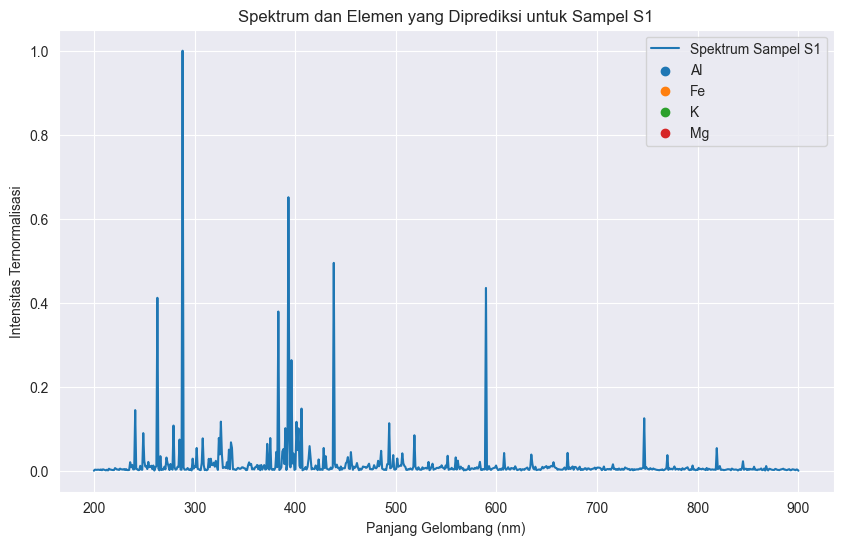

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S2: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg', 'Na')]


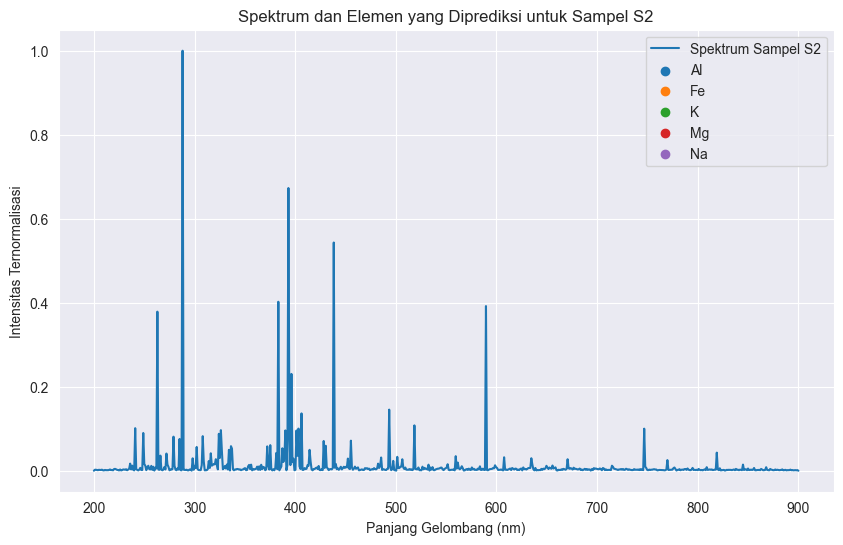

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S3: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg', 'Na')]


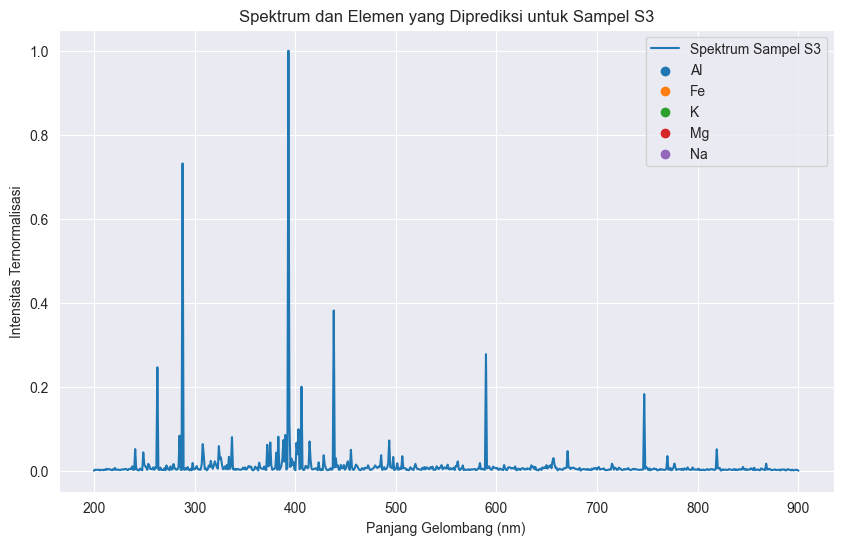

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sampel S4: Elemen yang diprediksi: [('Fe', 'Mg', 'Na')]


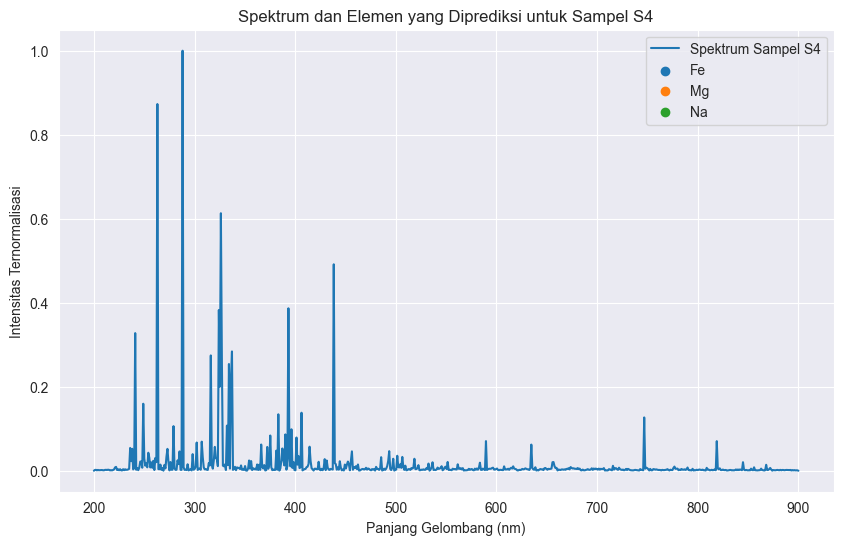

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sampel S5: Elemen yang diprediksi: [('Fe', 'K', 'Mg', 'Na')]


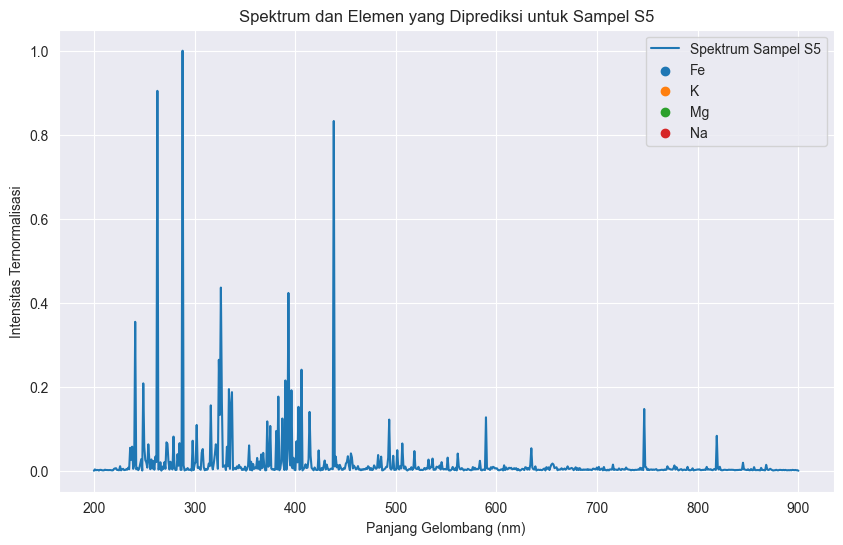

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S6: Elemen yang diprediksi: [('Fe', 'K', 'Mg', 'Na')]


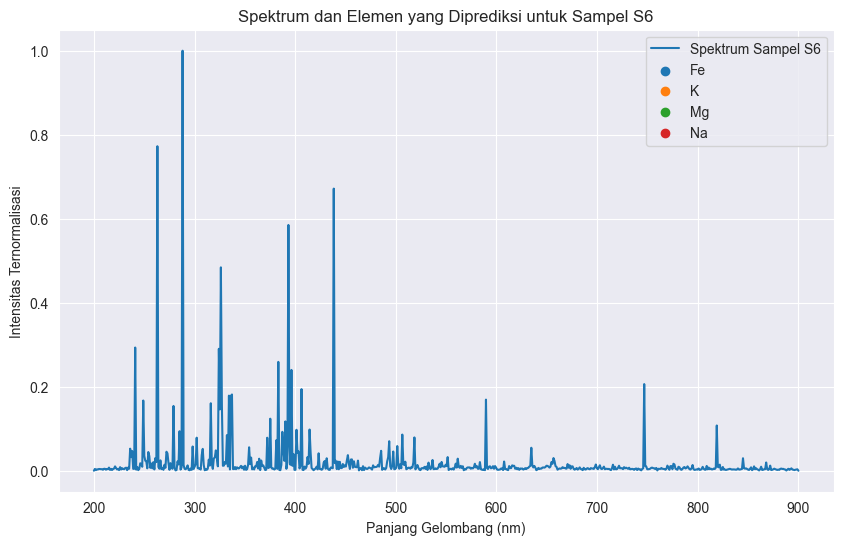

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sampel S7: Elemen yang diprediksi: [('Fe', 'K', 'Mg', 'Na')]


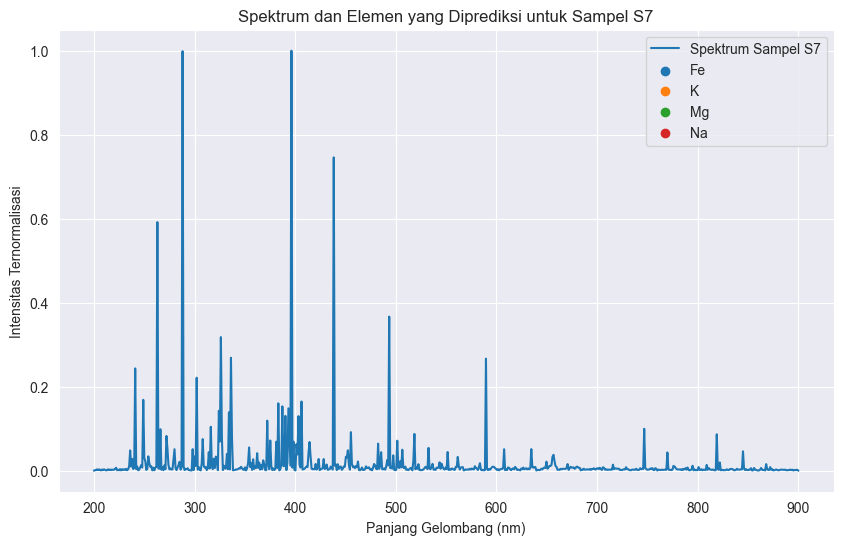

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sampel S8: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg', 'Na')]


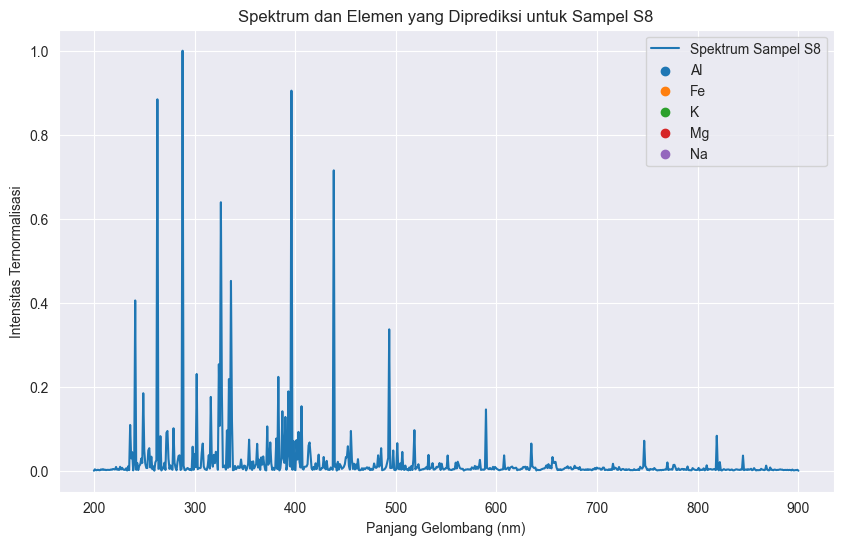

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S9: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg', 'Na')]


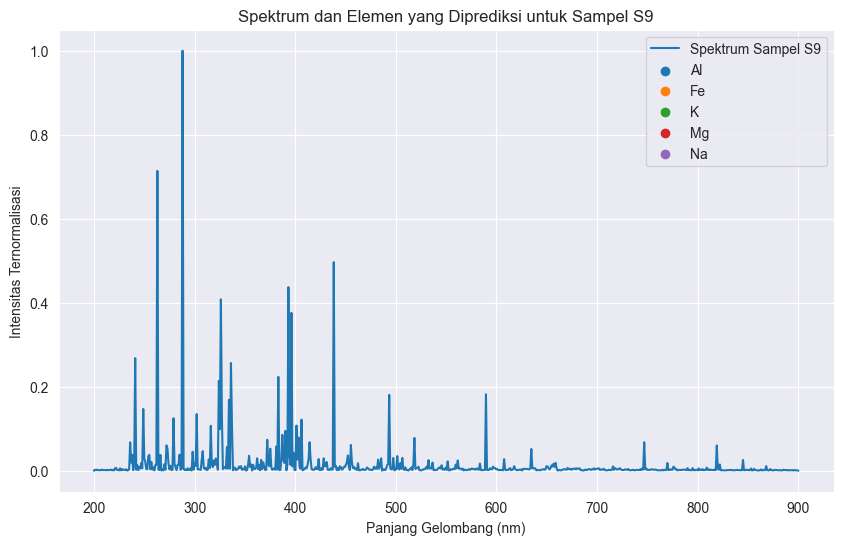

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sampel S10: Elemen yang diprediksi: [('Fe', 'K', 'Mg', 'Na')]


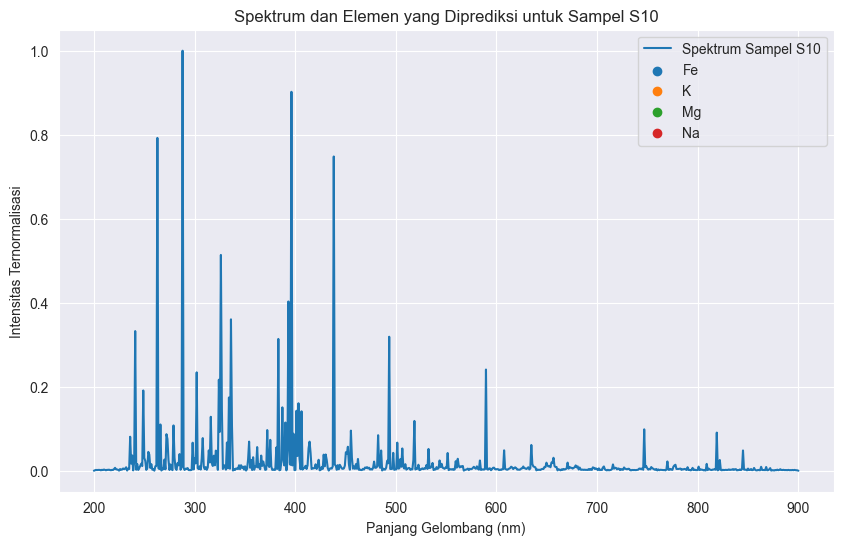

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sampel S11: Elemen yang diprediksi: [('Fe', 'Mg', 'Na')]


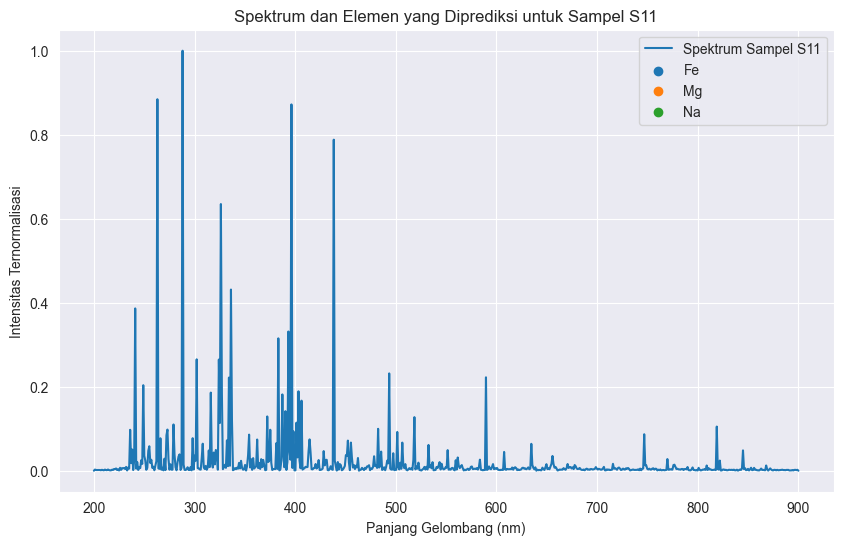

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sampel S12: Elemen yang diprediksi: [('Fe', 'K', 'Mg', 'Na')]


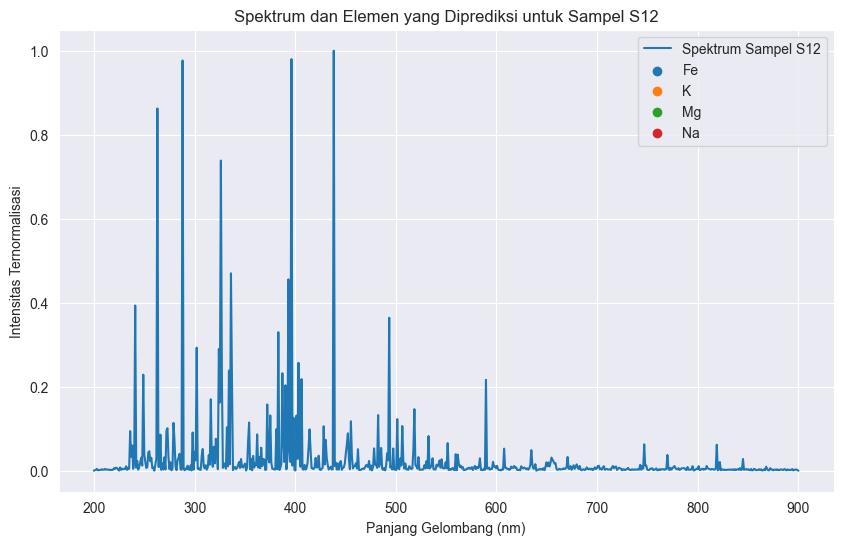

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sampel S13: Elemen yang diprediksi: [('Fe', 'K', 'Mg', 'Na')]


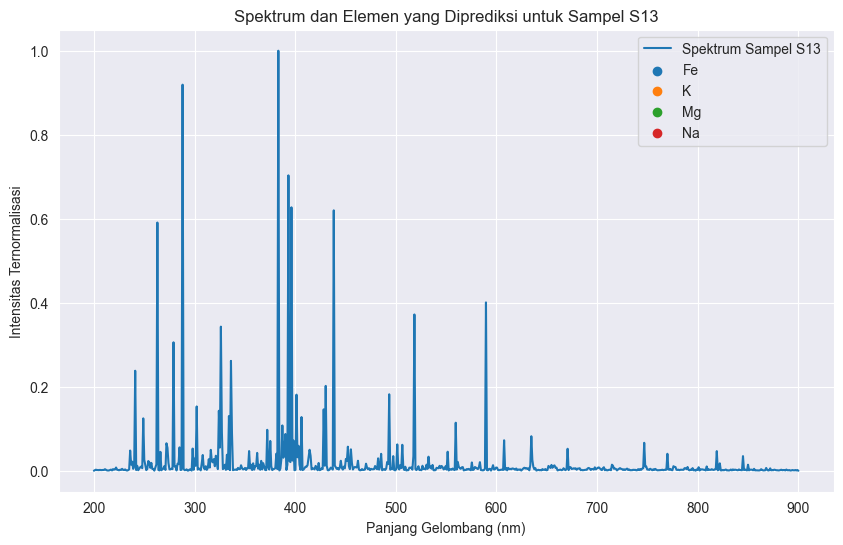

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S14: Elemen yang diprediksi: [('Fe', 'K', 'Mg', 'Na')]


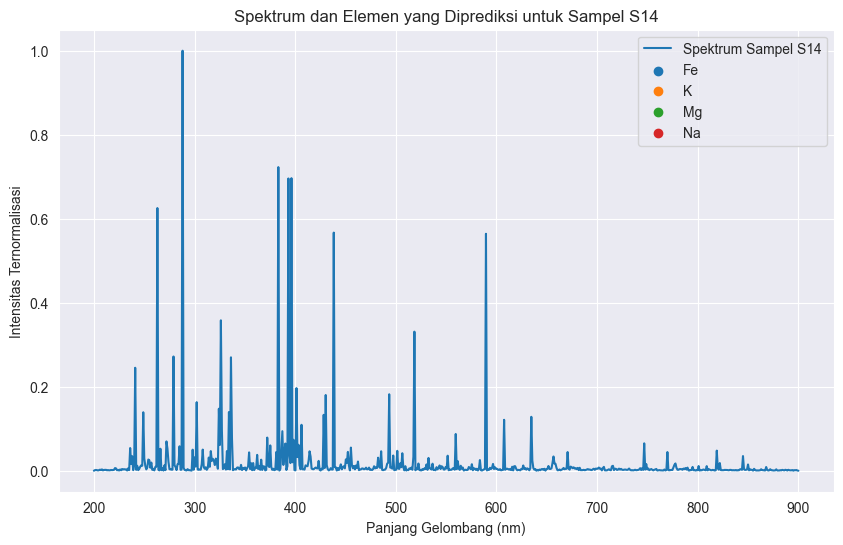

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sampel S15: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Mg', 'Na')]


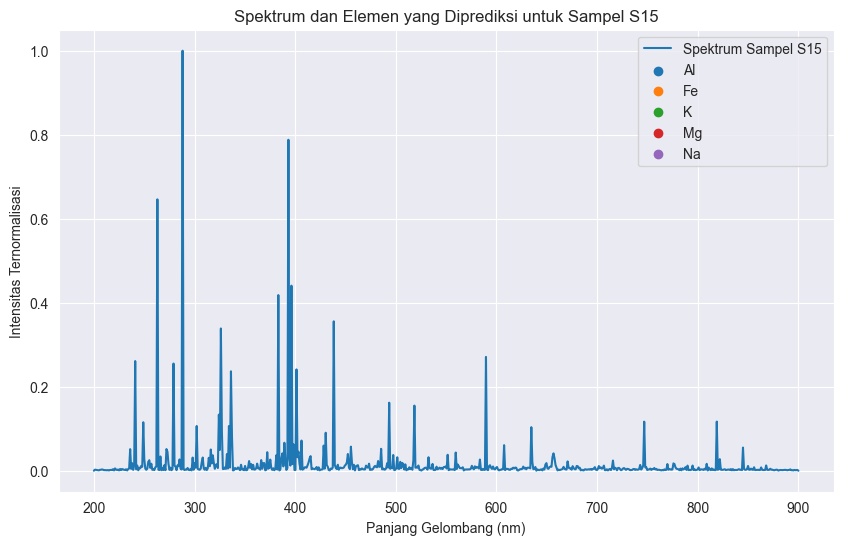

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sampel S16: Elemen yang diprediksi: [('Ca', 'Fe', 'K', 'Mg', 'Na')]


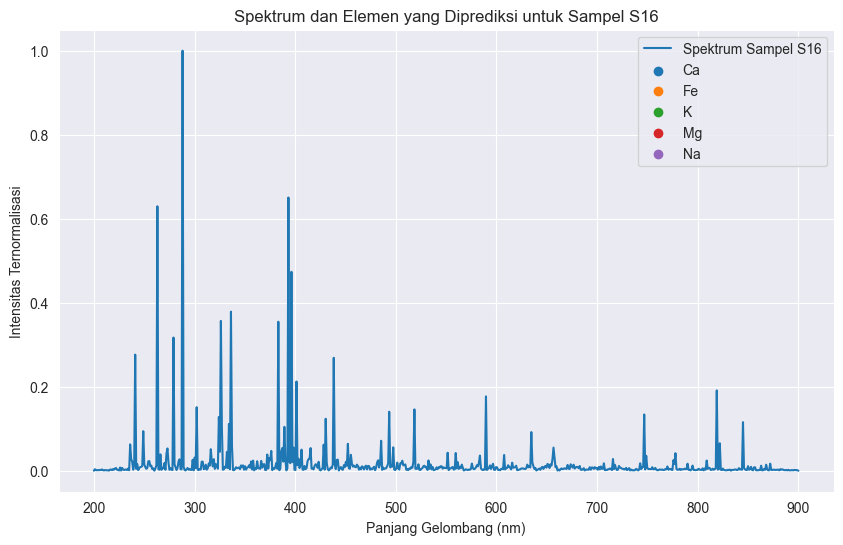

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sampel S17: Elemen yang diprediksi: [('Al', 'Ca', 'Fe', 'Mg', 'Na')]


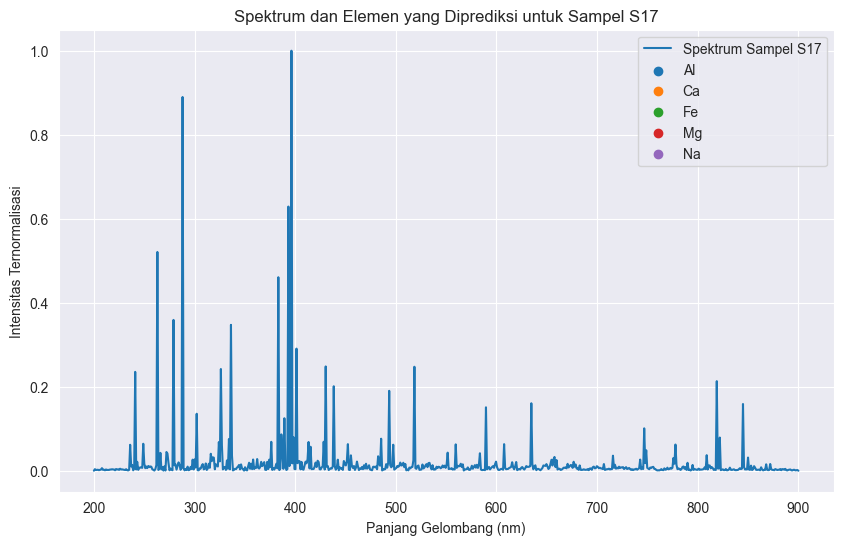

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sampel S18: Elemen yang diprediksi: [('Al', 'Ca', 'Fe', 'K', 'Na')]


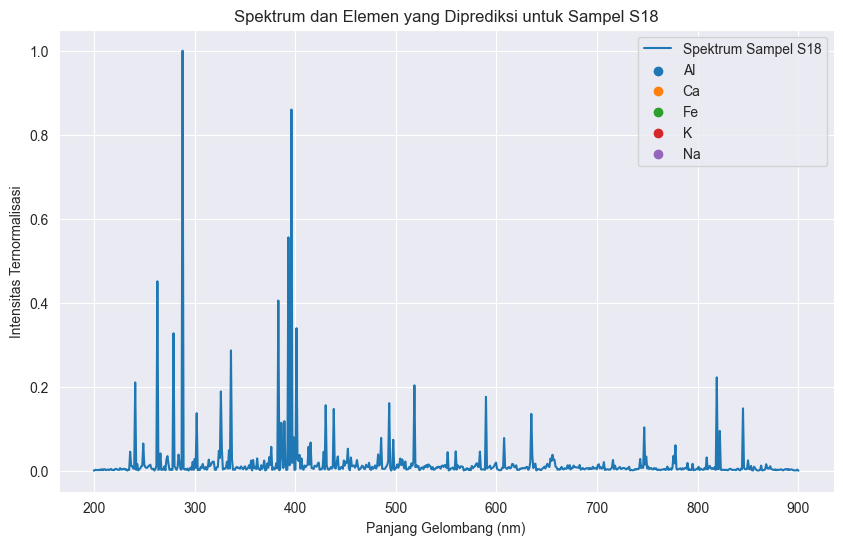

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sampel S19: Elemen yang diprediksi: [('Al', 'Fe', 'K', 'Na')]


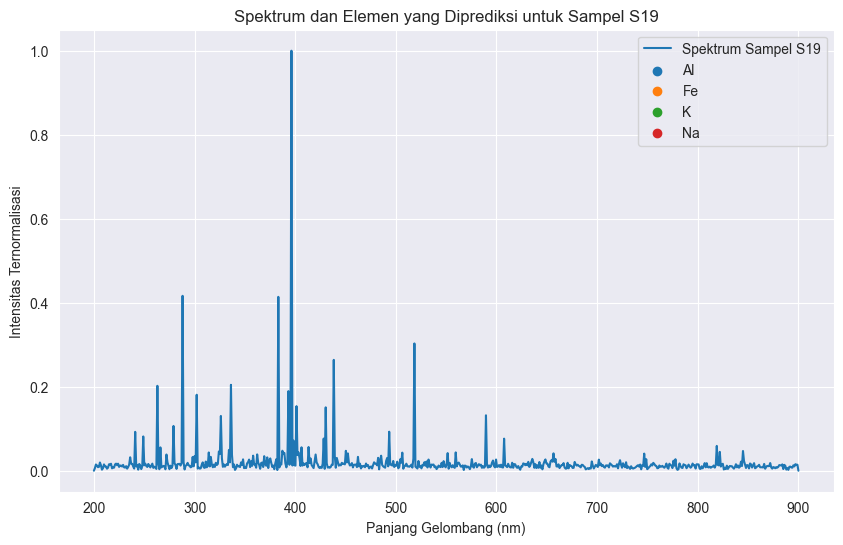

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sampel S20: Elemen yang diprediksi: [('Ca', 'Fe', 'K', 'Na')]


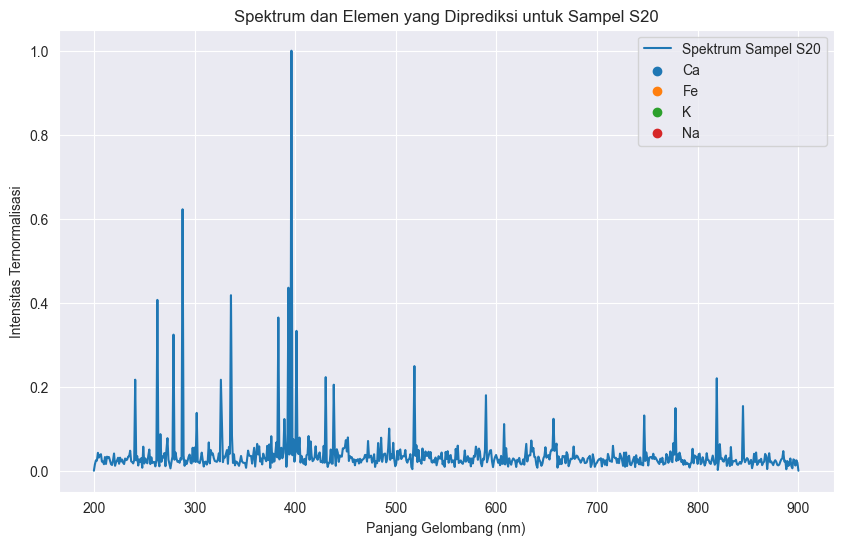

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S21: Elemen yang diprediksi: [('Fe', 'K', 'Na')]


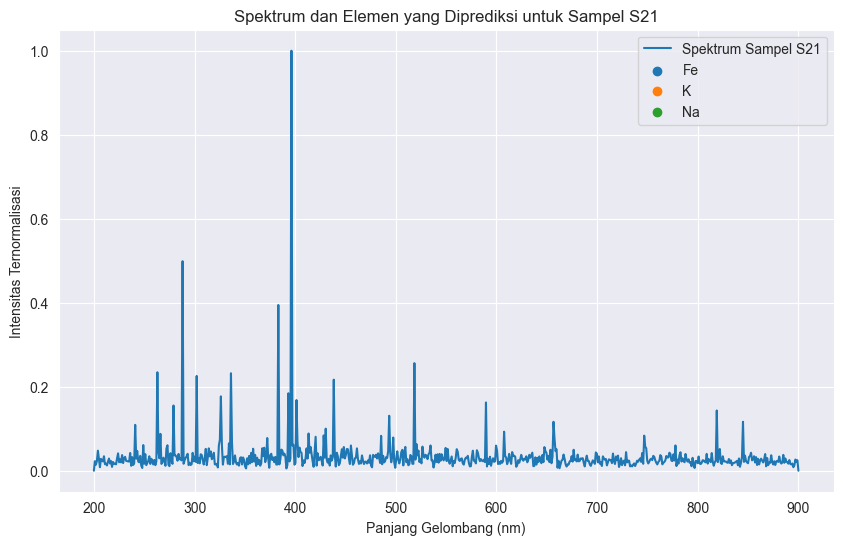

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Sampel S22: Elemen yang diprediksi: [('Ca', 'Fe', 'K', 'Na')]


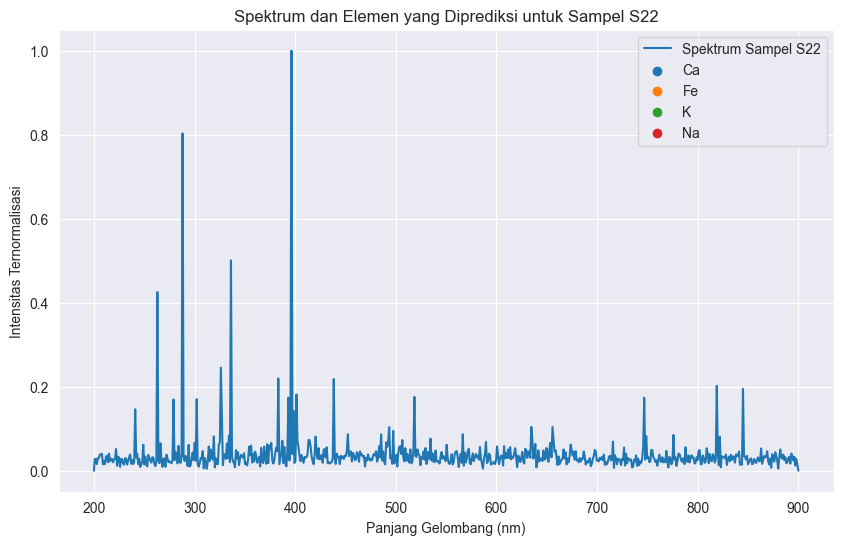

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sampel S23: Elemen yang diprediksi: [('Ca', 'Fe', 'K', 'Mg', 'Na')]


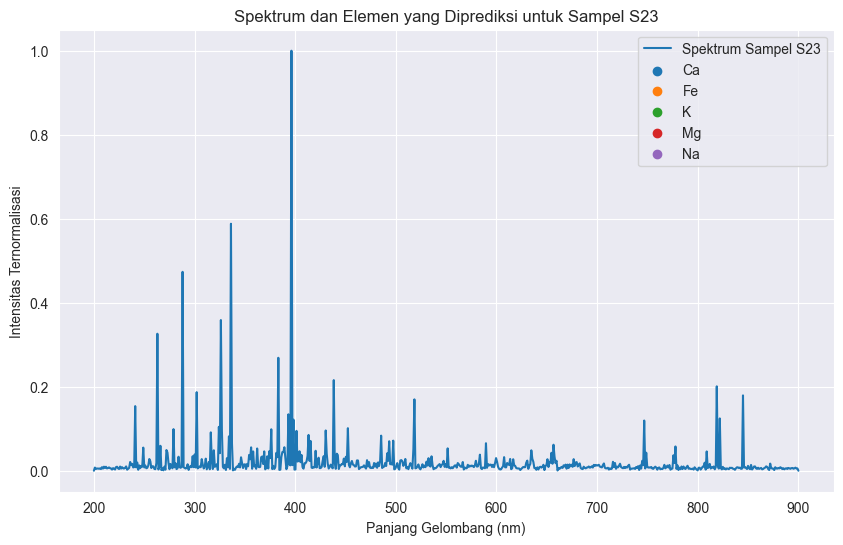

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Sampel S24: Elemen yang diprediksi: [('Ca', 'Fe', 'K', 'Na')]


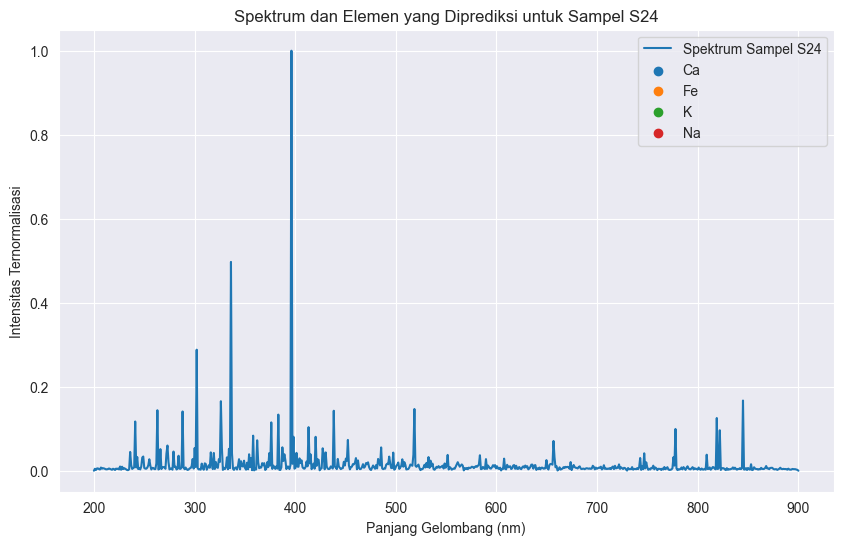

In [1]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib

def predict_spectrum_from_db(db_path, model, mlb, bins):
    # Koneksi ke database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Mendapatkan daftar sampel
    cursor.execute("SELECT DISTINCT sample_name FROM processed_spectrum")
    samples = [row[0] for row in cursor.fetchall()]
    
    for sample_name in samples:
        # Mengambil data panjang gelombang dan intensitas untuk sampel tertentu
        cursor.execute("SELECT wavelength, intensity FROM processed_spectrum WHERE sample_name = ?", (sample_name,))
        data = cursor.fetchall()
        if not data:
            continue

        # Ekstraksi panjang gelombang dan intensitas
        wavelengths, intensities = zip(*data)
        wavelengths = np.array(wavelengths)
        intensities = np.array(intensities)
        
        # Interpolasi intensitas pada grid panjang gelombang yang ditentukan (bins)
        interpolated_intensities = np.interp(bins, wavelengths, intensities)
        interpolated_intensities = interpolated_intensities / np.max(interpolated_intensities)  # Normalisasi
        
        # Bentuk data untuk prediksi
        X_new = interpolated_intensities.reshape(1, len(bins), 1)
        
        # Prediksi elemen yang ada dalam spektrum
        y_pred = model.predict(X_new)
        predicted_elements = mlb.inverse_transform((y_pred > 0.5).astype(int))

        # Tampilkan hasil prediksi
        print(f"Sampel {sample_name}: Elemen yang diprediksi: {predicted_elements}")

        # Plot spektrum dengan titik prediksi
        plt.figure(figsize=(10, 6))
        plt.plot(bins, interpolated_intensities, label=f'Spektrum Sampel {sample_name}')
        plt.xlabel('Panjang Gelombang (nm)')
        plt.ylabel('Intensitas Ternormalisasi')
        plt.title(f'Spektrum dan Elemen yang Diprediksi untuk Sampel {sample_name}')
        
        # Tandai posisi prediksi elemen pada spektrum
        for element in predicted_elements[0]:
            # Anda bisa mengatur panjang gelombang atau lokasi marker sesuai karakteristik elemen yang diprediksi
            plt.scatter([], [], label=element)  # Placeholder untuk legenda
        
        # Tampilkan legenda dan plot
        plt.legend(loc='upper right')
        plt.show()

    # Menutup koneksi database
    conn.close()

# Load model dan encoder
model = load_model('cnn_bilstm_spectrum_model.h5')
mlb = joblib.load('multilabel_binarizer.pkl')

# Definisikan bins untuk interpolasi (harus konsisten dengan data pelatihan)
bins = np.linspace(200, 900, 700)

# Prediksi spektrum dari database dan visualisasikan
predict_spectrum_from_db('processed_spectra.db', model, mlb, bins)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
Sampel S1: Elemen yang diprediksi: [('Fe',)]


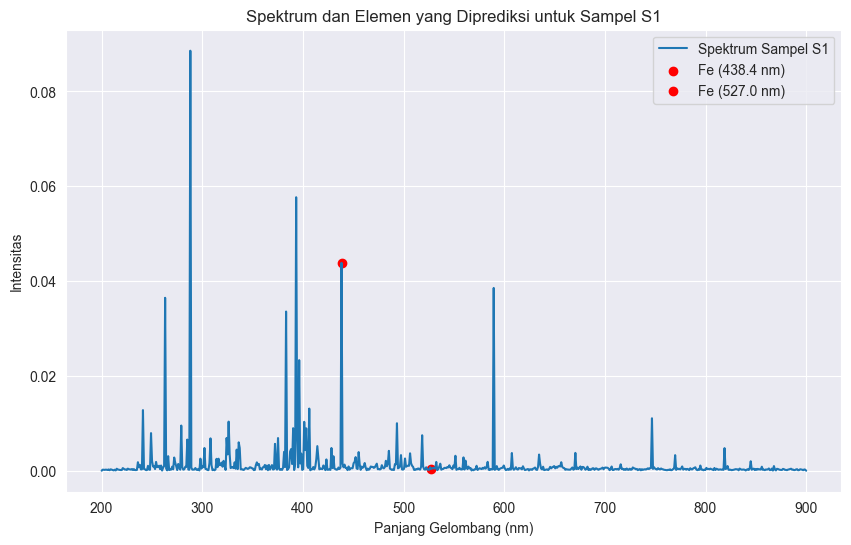

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sampel S2: Elemen yang diprediksi: [('Al', 'Fe', 'Na')]


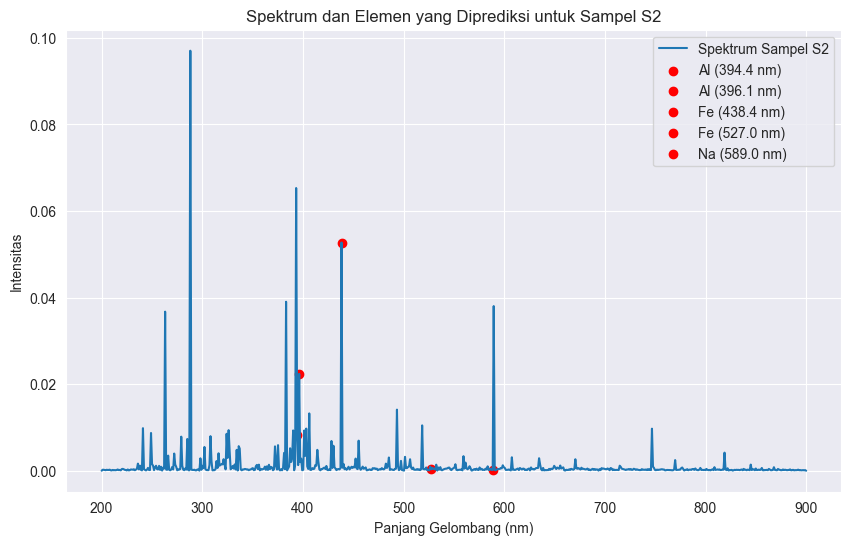

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sampel S3: Elemen yang diprediksi: [('Al', 'Fe')]


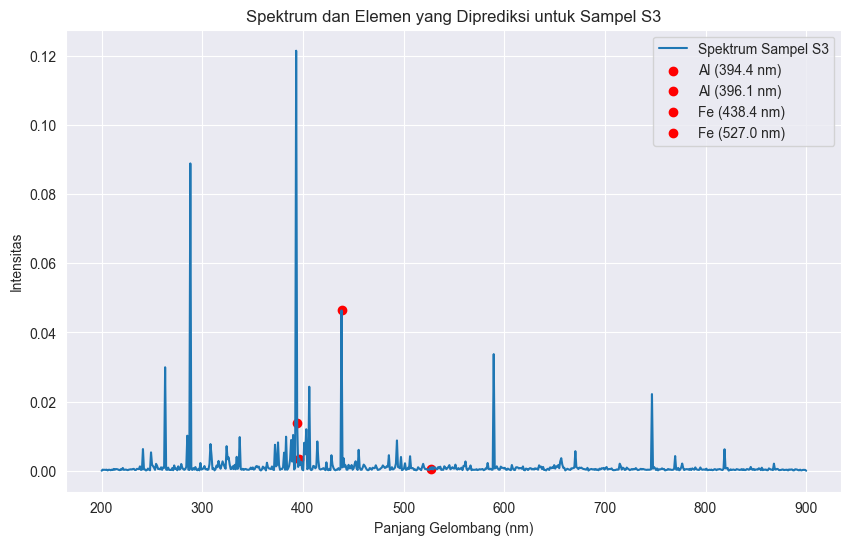

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S4: Elemen yang diprediksi: [('Al', 'Fe', 'Na')]


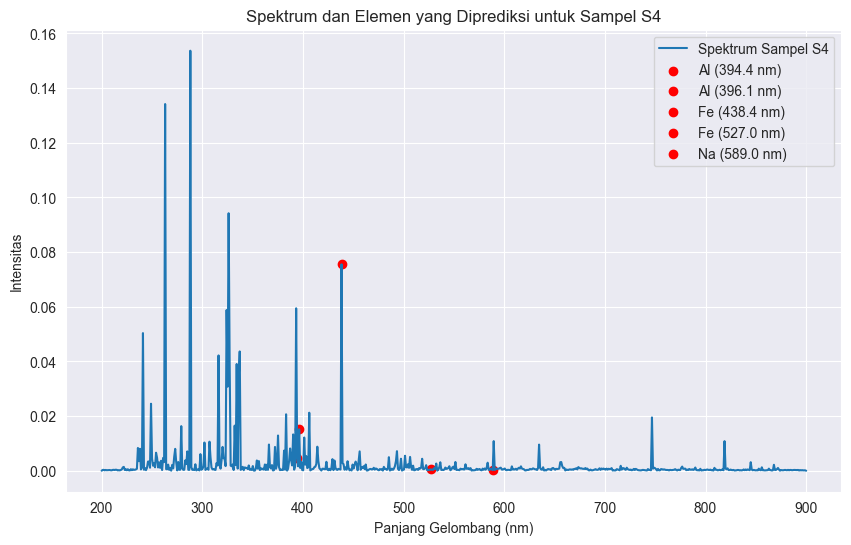

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sampel S5: Elemen yang diprediksi: [('Al', 'Fe', 'Na')]


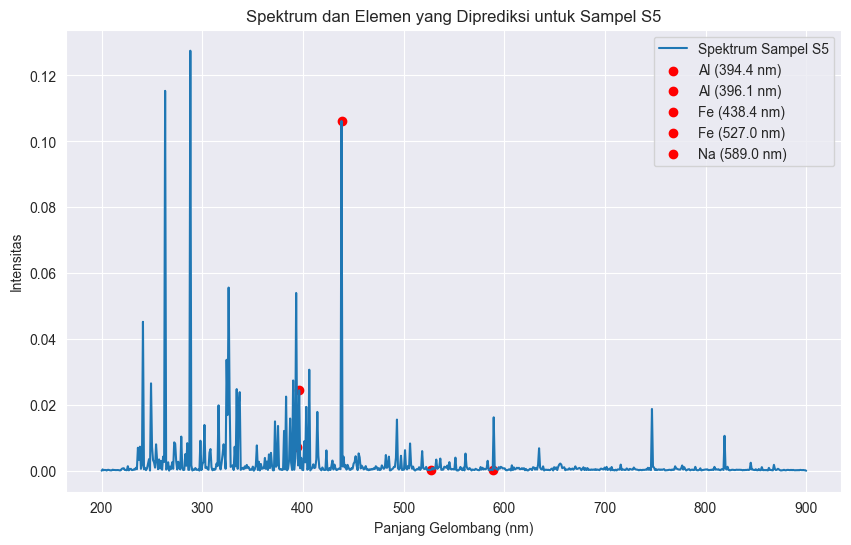

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S6: Elemen yang diprediksi: [('Al', 'Fe', 'Na')]


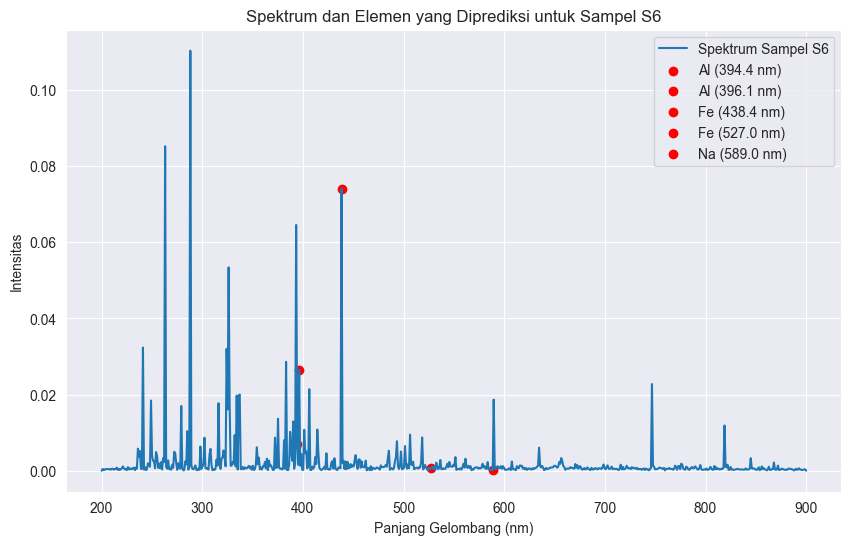

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S7: Elemen yang diprediksi: [('Al', 'Fe', 'Na')]


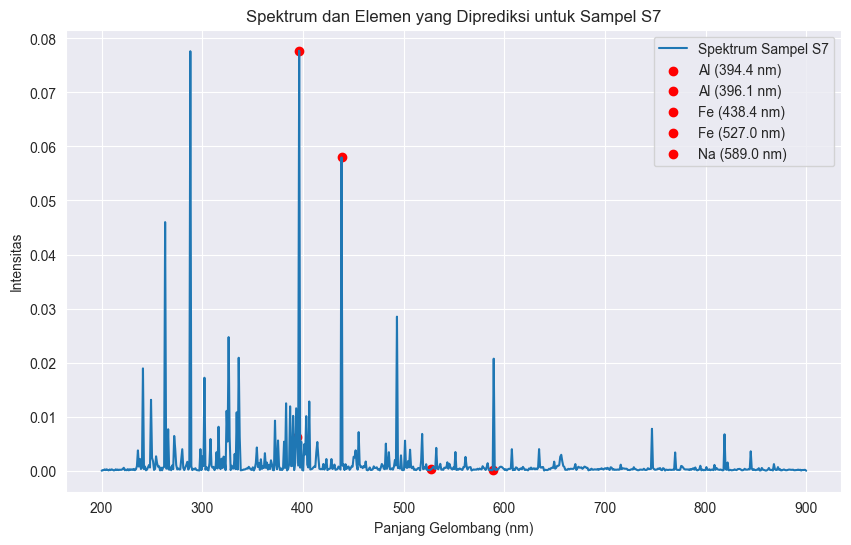

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sampel S8: Elemen yang diprediksi: [('Al', 'Fe', 'Na')]


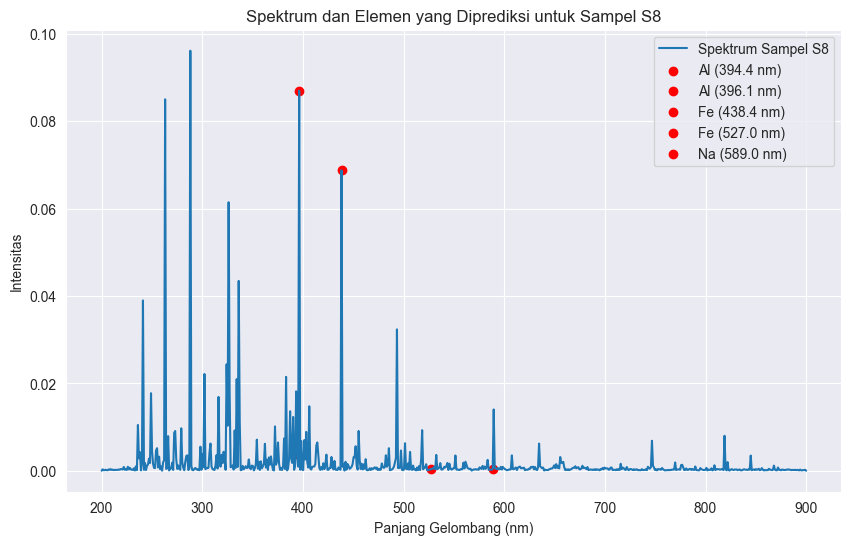

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sampel S9: Elemen yang diprediksi: [('Al', 'Fe')]


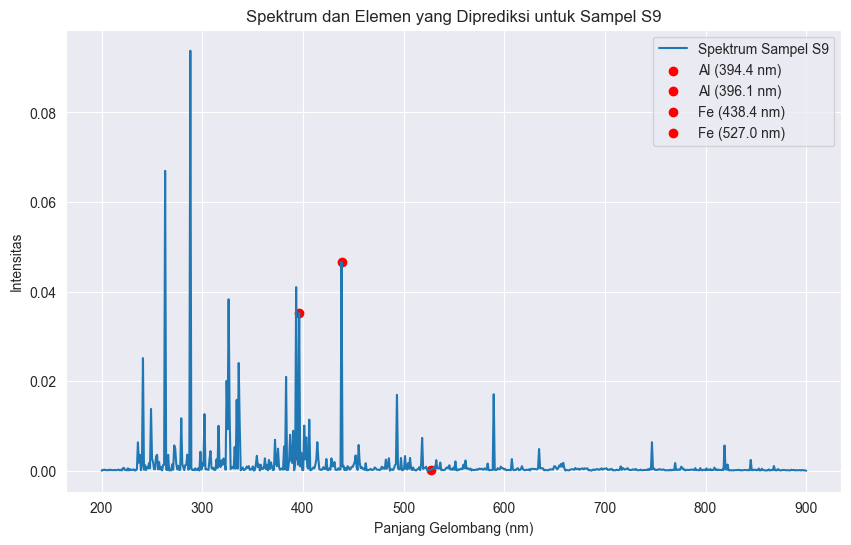

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Sampel S10: Elemen yang diprediksi: [('Al', 'Fe', 'Na')]


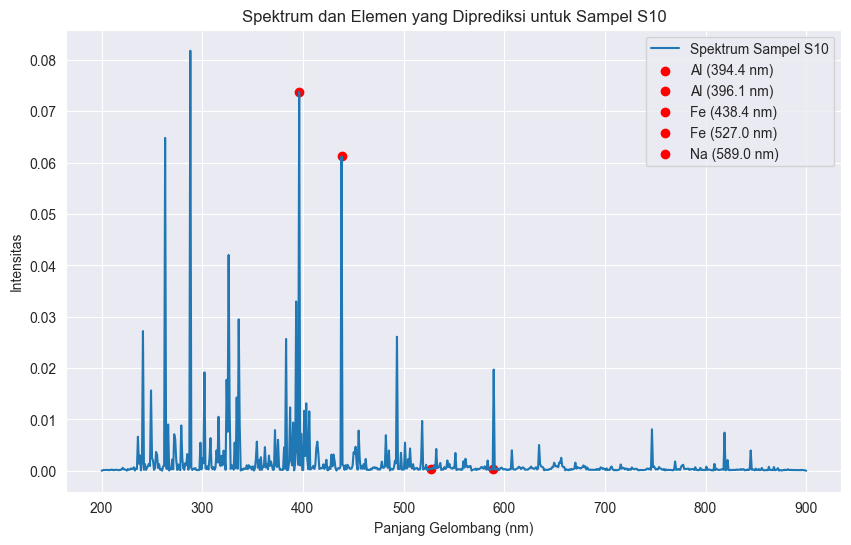

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sampel S11: Elemen yang diprediksi: [('Al', 'Fe', 'Na')]


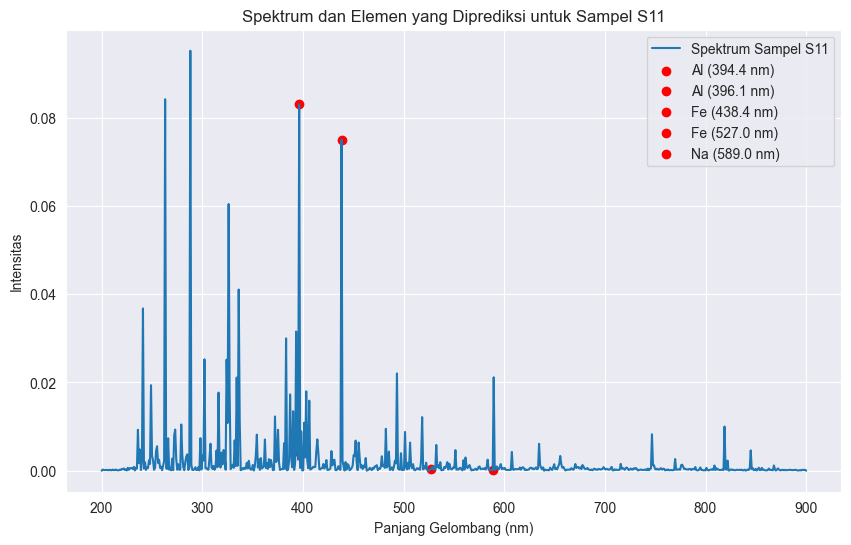

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sampel S12: Elemen yang diprediksi: [('Al', 'Fe')]


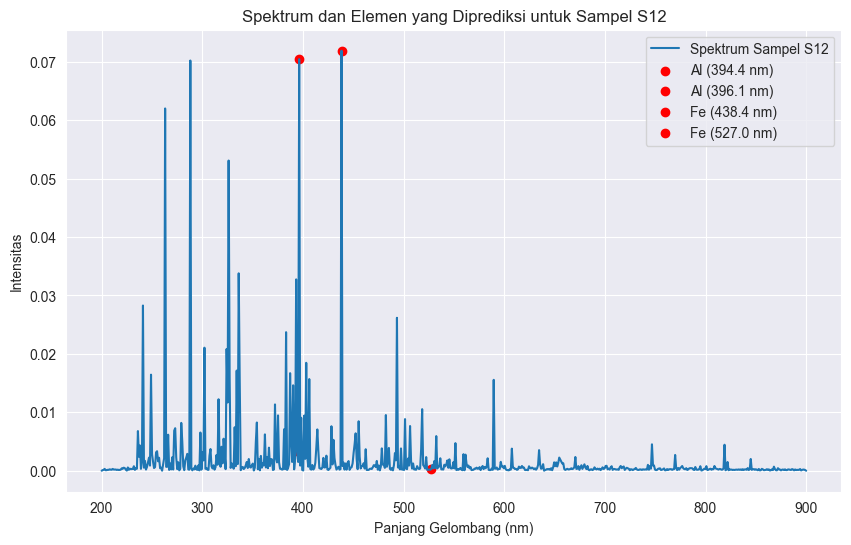

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Sampel S13: Elemen yang diprediksi: [('Fe', 'Mg')]


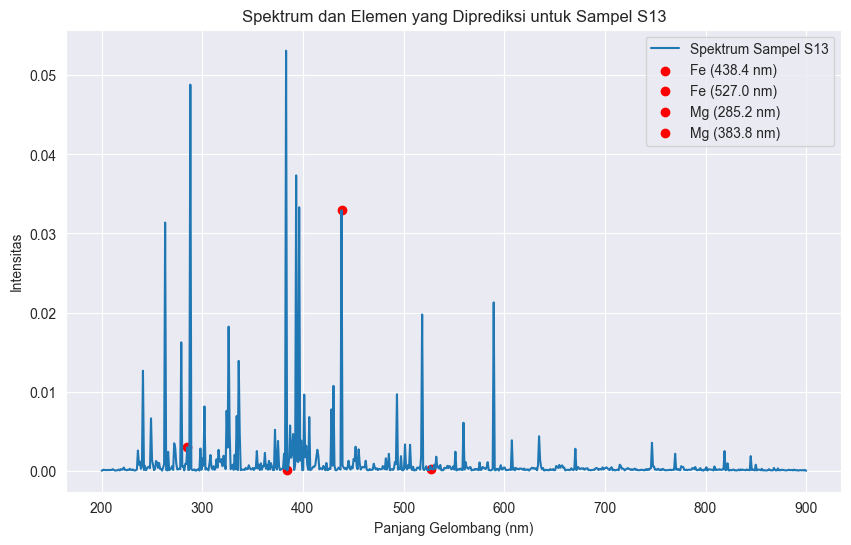

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Sampel S14: Elemen yang diprediksi: [('Fe', 'Mg')]


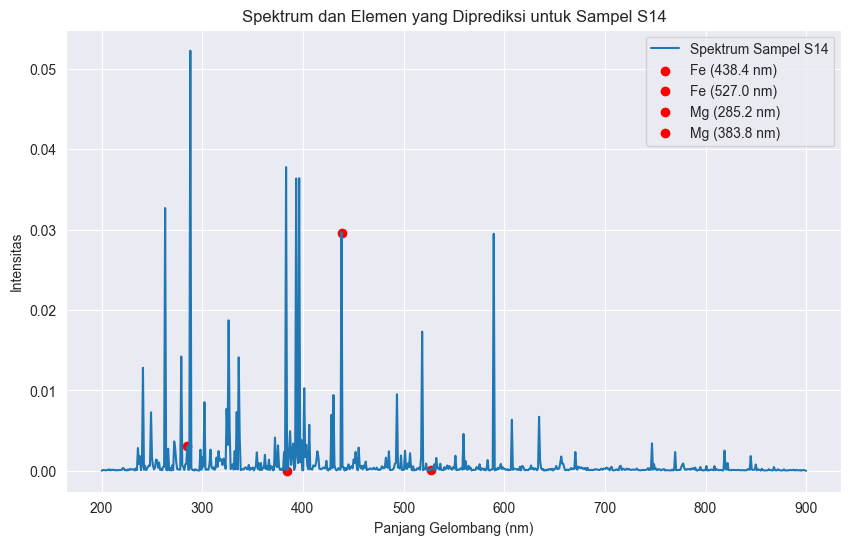

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Sampel S15: Elemen yang diprediksi: [('Al', 'Fe', 'Mg')]


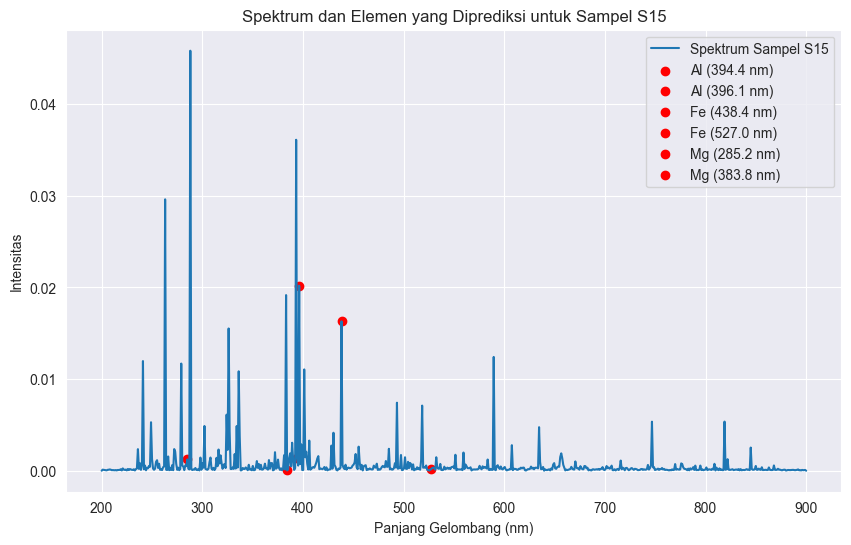

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Sampel S16: Elemen yang diprediksi: [('Fe', 'Mg')]


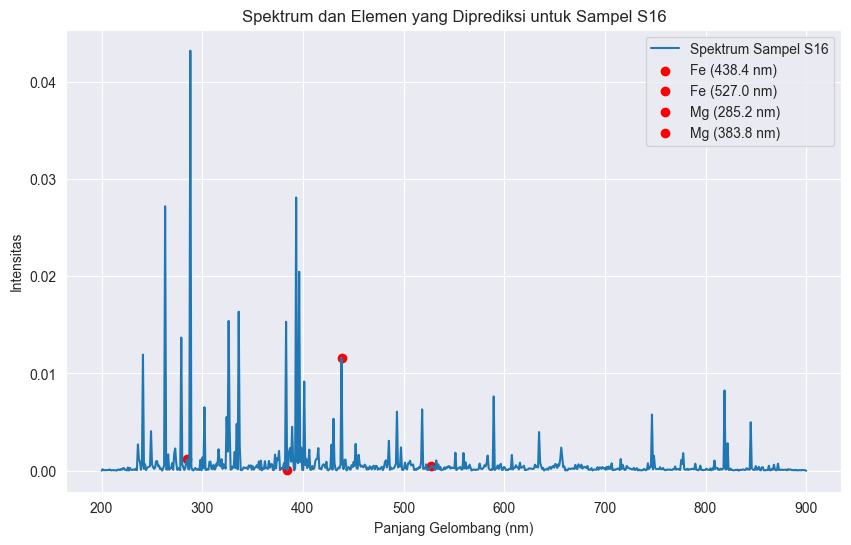

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Sampel S17: Elemen yang diprediksi: [('Fe',)]


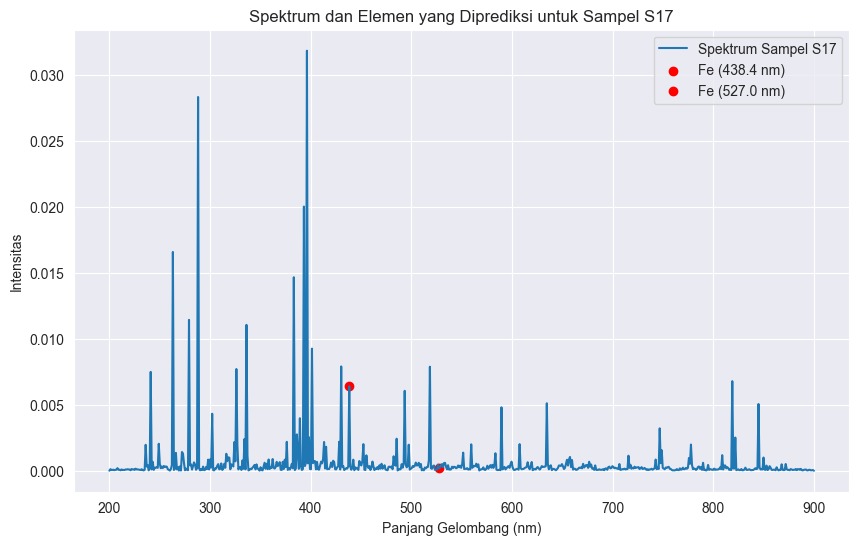

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sampel S18: Elemen yang diprediksi: [('Fe',)]


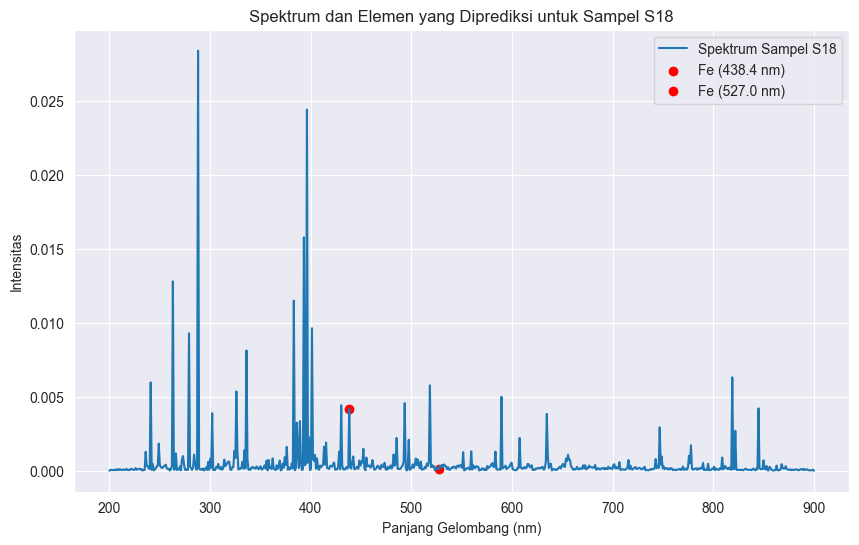

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S19: Elemen yang diprediksi: [('Al', 'Fe', 'K')]


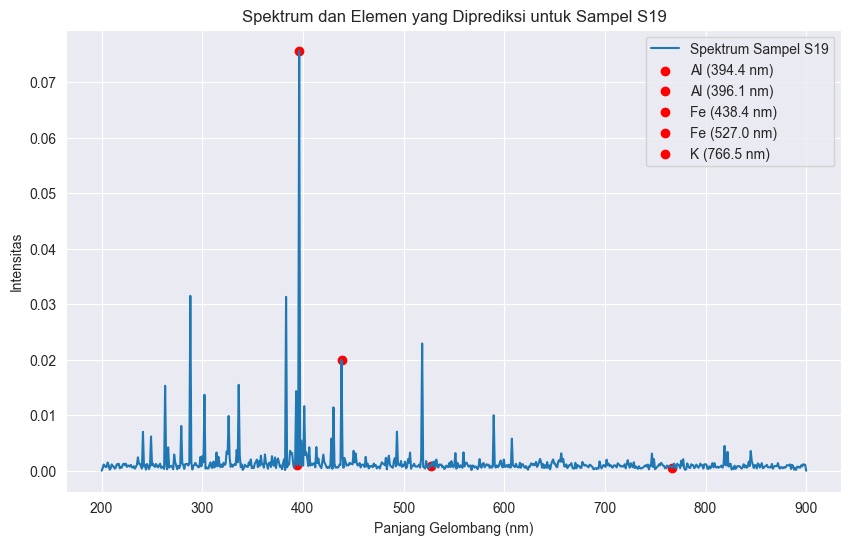

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Sampel S20: Elemen yang diprediksi: [('Al', 'Fe', 'K')]


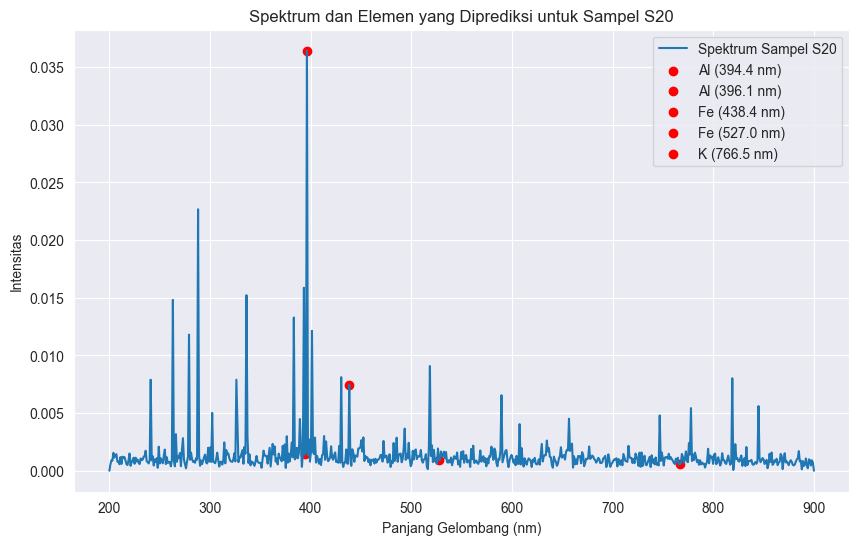

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Sampel S21: Elemen yang diprediksi: [('Al', 'Fe', 'K')]


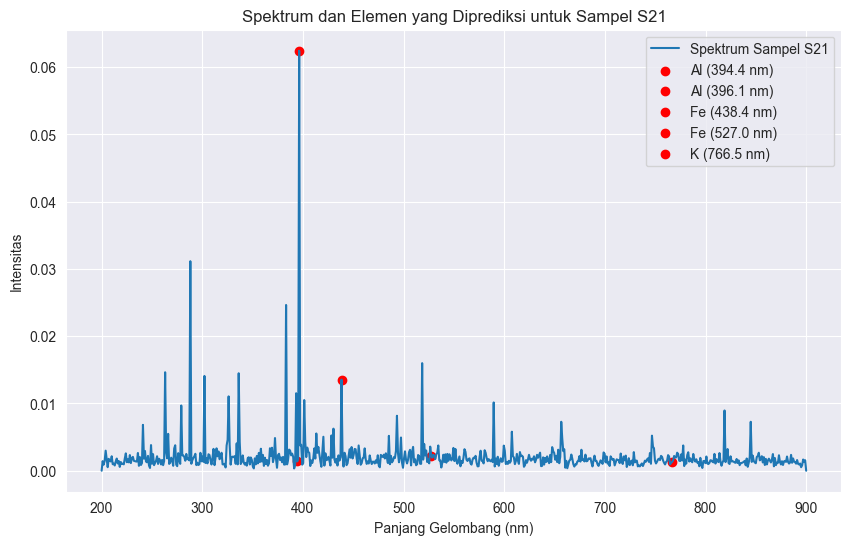

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Sampel S22: Elemen yang diprediksi: [('Al', 'Fe', 'K')]


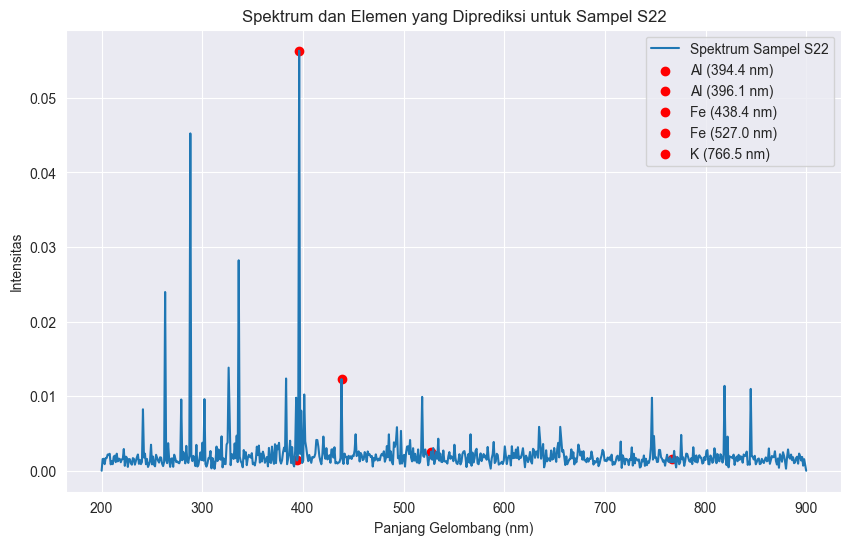

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Sampel S23: Elemen yang diprediksi: [('Al', 'Fe', 'K')]


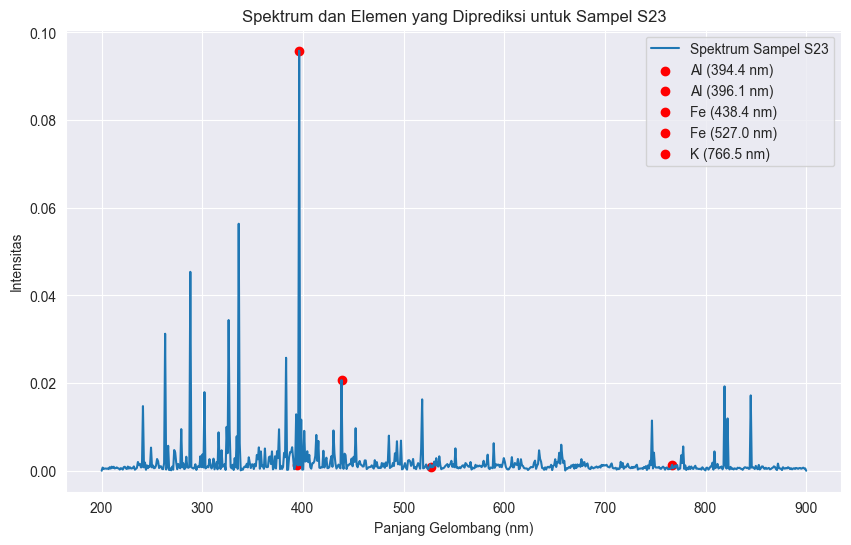

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Sampel S24: Elemen yang diprediksi: [('Al', 'Fe', 'K')]


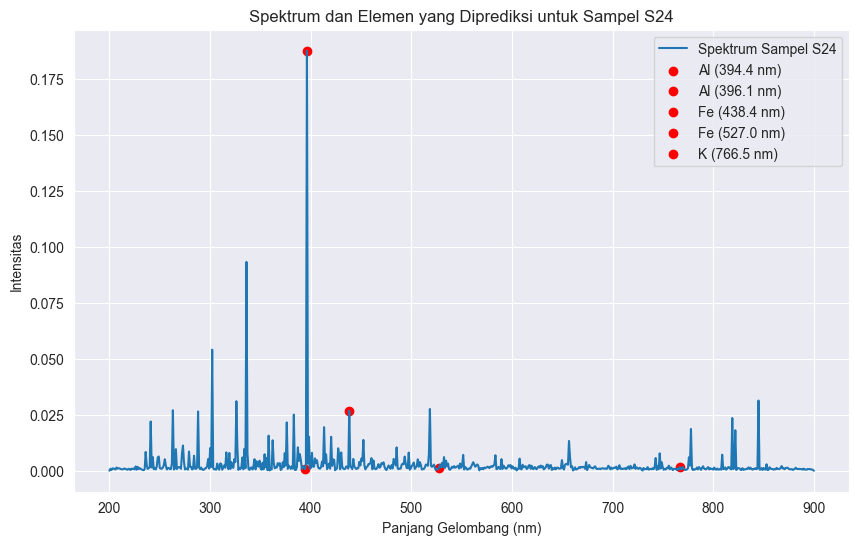

In [2]:
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib

# Fungsi untuk mendapatkan panjang gelombang karakteristik dari setiap elemen
def get_characteristic_wavelength(element):
    characteristic_wavelengths = {
        'Ca': [422.7, 393.4],  # Contoh panjang gelombang untuk Ca
        'Fe': [438.4, 527.0],  # Contoh panjang gelombang untuk Fe
        'Mg': [285.2, 383.8],  # Contoh panjang gelombang untuk Mg
        'Na': [589.0],         # Contoh panjang gelombang untuk Na
        'K': [766.5],          # Contoh panjang gelombang untuk K
        'Al': [394.4, 396.1],  # Contoh panjang gelombang untuk Al
        'Si': [288.2, 251.6]   # Contoh panjang gelombang untuk Si
    }
    return characteristic_wavelengths.get(element, [])

def predict_spectrum_from_db(db_path, model, mlb, bins):
    # Koneksi ke database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Mendapatkan daftar sampel
    cursor.execute("SELECT DISTINCT sample_name FROM processed_spectrum")
    samples = [row[0] for row in cursor.fetchall()]
    
    for sample_name in samples:
        # Mengambil data panjang gelombang dan intensitas untuk sampel tertentu
        cursor.execute("SELECT wavelength, intensity FROM processed_spectrum WHERE sample_name = ?", (sample_name,))
        data = cursor.fetchall()
        if not data:
            continue

        # Ekstraksi panjang gelombang dan intensitas
        wavelengths, intensities = zip(*data)
        wavelengths = np.array(wavelengths)
        intensities = np.array(intensities)
        
        # Interpolasi intensitas pada grid panjang gelombang yang ditentukan (bins)
        interpolated_intensities = np.interp(bins, wavelengths, intensities)
        
        # Bentuk data untuk prediksi (tetap dalam bentuk asli tanpa normalisasi)
        X_new = interpolated_intensities.reshape(1, len(bins), 1)
        
        # Prediksi elemen yang ada dalam spektrum
        y_pred = model.predict(X_new)
        predicted_elements = mlb.inverse_transform((y_pred > 0.5).astype(int))

        # Tampilkan hasil prediksi
        print(f"Sampel {sample_name}: Elemen yang diprediksi: {predicted_elements}")

        # Plot spektrum dengan titik prediksi
        plt.figure(figsize=(10, 6))
        plt.plot(bins, interpolated_intensities, label=f'Spektrum Sampel {sample_name}')
        plt.xlabel('Panjang Gelombang (nm)')
        plt.ylabel('Intensitas')
        plt.title(f'Spektrum dan Elemen yang Diprediksi untuk Sampel {sample_name}')
        
        # Tandai posisi prediksi elemen pada spektrum
        for element in predicted_elements[0]:
            characteristic_wavelengths = get_characteristic_wavelength(element)
            for wl in characteristic_wavelengths:
                # Menandai lokasi panjang gelombang karakteristik pada spektrum
                idx = np.abs(bins - wl).argmin()  # Cari indeks terdekat di bins
                plt.scatter(bins[idx], interpolated_intensities[idx], label=f'{element} ({wl} nm)', marker='o', color='red')
        
        # Tampilkan legenda dan plot
        plt.legend(loc='upper right')
        plt.show()

    # Menutup koneksi database
    conn.close()

# Load model dan encoder
model = load_model('cnn_bilstm_spectrum_model.h5')
mlb = joblib.load('multilabel_binarizer.pkl')

# Definisikan bins untuk interpolasi (harus konsisten dengan data pelatihan)
bins = np.linspace(200, 900, 700)

# Prediksi spektrum dari database dan visualisasikan
predict_spectrum_from_db('processed_spectra.db', model, mlb, bins)

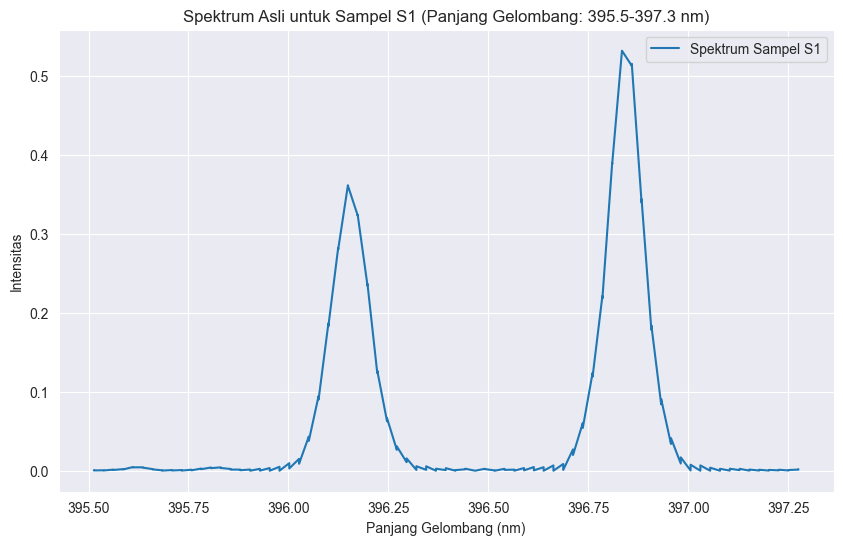

In [13]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

def plot_sample_spectrum(db_path, sample_name, lower_bound=None, upper_bound=None):
    # Koneksi ke database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Mengambil data panjang gelombang dan intensitas untuk sampel tertentu
    cursor.execute("SELECT wavelength, intensity FROM processed_spectrum WHERE sample_name = ?", (sample_name,))
    data = cursor.fetchall()
    
    # Menutup koneksi database
    conn.close()
    
    # Jika data tidak ditemukan, tampilkan pesan
    if not data:
        print(f"Tidak ada data untuk sampel {sample_name}")
        return

    # Ekstraksi panjang gelombang dan intensitas
    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths)
    intensities = np.array(intensities)
    
    # Filter data berdasarkan batas atas dan bawah jika diberikan
    if lower_bound is not None:
        mask = wavelengths >= lower_bound
        wavelengths = wavelengths[mask]
        intensities = intensities[mask]
    if upper_bound is not None:
        mask = wavelengths <= upper_bound
        wavelengths = wavelengths[mask]
        intensities = intensities[mask]
    
    # Plot spektrum
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, intensities, label=f'Spektrum Sampel {sample_name}')
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas')
    plt.title(f'Spektrum Asli untuk Sampel {sample_name} (Panjang Gelombang: {lower_bound}-{upper_bound} nm)')
    plt.legend(loc='upper right')
    plt.show()

# Path ke database dan nama sampel
db_path = 'processed_spectra.db'
sample_name = 'S1'

# Memanggil fungsi untuk plot spektrum dengan batas panjang gelombang tertentu
plot_sample_spectrum(db_path, sample_name, lower_bound=395.5, upper_bound=397.3)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from hplc.quant import Chromatogram

def snip_baseline_correction(spectrum_df, num_iterations):
    """
    Apply SNIP baseline correction to a spectrum.
    
    Parameters:
    spectrum_df (pd.DataFrame): DataFrame with 'wavelength' and 'intensity' columns.
    num_iterations (int): Number of SNIP iterations to run.
    
    Returns:
    pd.DataFrame: DataFrame with corrected intensity values.
    """
    intensity = spectrum_df['intensity'].values
    corrected_intensity = intensity.copy()

    for _ in range(num_iterations):
        for i in range(1, len(intensity) - 1):
            corrected_intensity[i] = min(corrected_intensity[i], 
                                         (corrected_intensity[i - 1] + corrected_intensity[i + 1]) / 2)
    
    spectrum_df['corrected_intensity'] = intensity - corrected_intensity
    spectrum_df['baseline'] = corrected_intensity

    return spectrum_df

def gets(db_path, sample_name, lower_bound=None, upper_bound=None):
    """
    Ambil data spektrum dari database berdasarkan sample_name
    dan rentang panjang gelombang (jika diberikan batas atas dan bawah).
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Mengambil data panjang gelombang dan intensitas untuk sampel tertentu
    cursor.execute("SELECT wavelength, intensity FROM spectrum_data WHERE sample_name = ?", (sample_name,))
    data = cursor.fetchall()
    
    # Menutup koneksi database
    conn.close()
    
    # Jika data tidak ditemukan, tampilkan pesan dan return None
    if not data:
        print(f"Tidak ada data untuk sampel {sample_name}")
        return None

    # Ekstraksi panjang gelombang dan intensitas
    wavelengths, intensities = zip(*data)
    wavelengths = np.array(wavelengths)
    intensities = np.array(intensities)
    
    # Filter data berdasarkan batas atas dan bawah jika diberikan
    if lower_bound is not None:
        mask = wavelengths >= lower_bound
        wavelengths = wavelengths[mask]
        intensities = intensities[mask]
    if upper_bound is not None:
        mask = wavelengths <= upper_bound
        wavelengths = wavelengths[mask]
        intensities = intensities[mask]

    # Buat DataFrame dari hasil ekstraksi dan filter
    spectrum_df = pd.DataFrame({
        'wavelength': wavelengths,
        'intensity': intensities
    })

    return spectrum_df

# Parameter utama
db_path = 'tanah_vulkanik.db'
sample_name = 'S1'
lower_bound = 200
upper_bound = 900
num_iterations = 1500  # Jumlah iterasi untuk baseline correction

# Ambil data spektrum dari database
spectrum_df = gets(db_path, sample_name, lower_bound=lower_bound, upper_bound=upper_bound)

# Lanjutkan jika spectrum_df berhasil didapatkan
if spectrum_df is not None:
    # Terapkan koreksi baseline SNIP
    corrected_spectrum_df = snip_baseline_correction(spectrum_df, num_iterations)
    
    # Sesuaikan kolom untuk kompatibilitas dengan Chromatogram
    # Gunakan kolom corrected_intensity setelah baseline correction
    corrected_spectrum_df.rename(columns={'wavelength': 'time_min', 'corrected_intensity': 'intensity_mV'}, inplace=True)
    
    # Buat objek Chromatogram dengan rentang panjang gelombang yang dipilih
    chrom = Chromatogram(corrected_spectrum_df, cols={'time': 'time_min', 'signal': 'intensity_mV'}, time_window=[lower_bound, upper_bound])

    # Terapkan filter prominence untuk mendeteksi puncak
    prominence = 0.01  # Atur filter prominence sesuai kebutuhan Anda
    peaks = chrom.fit_peaks(prominence=prominence)
    
    # Tampilkan hasil deteksi puncak
    chrom.show()

    # Menampilkan jumlah puncak yang terdeteksi
    num_peaks = len(peaks)
    print(f"Jumlah puncak yang terdeteksi: {num_peaks}")
else:
    print("Gagal memuat data spektrum.")

Deconvolving mixture:   8%|▊         | 31/368 [00:13<02:28,  2.27it/s]


ValueError: `x0` is infeasible.